# IMPORTS

In [0]:
#INSTALLATIONS
!mkdir models
!pip install -q keras
import keras
!pip install -q tqdm
import tqdm
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

#LE FUTUR WESH
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#CLASSIQUES
from google.colab import files, auth
from oauth2client.client import GoogleCredentials
import numpy as np
np.random.seed(1000)
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from tqdm import tqdm
import matplotlib.pyplot as plt
import timeit
import sklearn.metrics as sklm
import copy
import types as python_types
import warnings

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('ATTENTION ! PAS DE GPU !')
else:
  print('Found GPU at: {}'.format(device_name))

#KERAS
import keras
from keras import activations, initializers, regularizers, constraints,metrics
from keras.legacy import interfaces
from keras.engine import InputSpec, Layer
from keras.layers import Input,BatchNormalization
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.utils.generic_utils import func_dump, func_load, deserialize_keras_object

# DRIVE AUTHENTIFICATION
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# CONSTANTES

In [0]:
# QUELQUES VARIABLES

adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles
adam = Adam(lr=0.0002, beta_1=0.5)

randomVectorSize = 100

d_losses = []
g_losses = []
c_losses = []
r_losses = []

# Nombre de learning steps par batch du DISCRIMINATOR
nb_step_discriminator = 1

# Seuil de score du DISCRIMINATOR en deça duquel on considere un exemple fake comme exemple classe 1 du REJECTOR
seuil_rejet_RejectionTraining = 0.45

# Seuil de score du DISCRIMINATOR au-delà duquel on considere un exemple fake comme exemple classe 0 du REJECTOR
seuil_accept_RejectionTraining = 0.55

# Nombre maximum d'exemples dans allGeneratedSamples
max_GeneratedSamples = 20000

# Permutation aléatoire des exemples dans allGeneratedSamples lorsque max_GeneratedSamples exemples est atteint
randomPermut_GeneratedSamples = True

# Tri des exemples dans allGeneratedSamples en fonction de leurs scores
sort_GeneratedSamples = False

# Cible des exemples negatifs 
target_neg = int(0)

# Cible des exemples positifs 
target_pos = int(1)

#Seuil à appliquer pour les prédictions du REJECTOR
seuil_rejector = 0.5

#Seuil à appliquer aux sorties du REJECTOR lors de l'entraînement du CLASSIFIER
seuil_rejector_to_train_classifier = 0.0

# Taux de decroisance de la variance des rbf units
Decrease_rate_alpha = 1.1  

# Utilisation des données perturbées
usePerturbatedData = False

# Nombre de classes dans MNIST
nb_classes = 10

# Choix des classes à traiter par le réseau
classes_train = np.random.choice(range(nb_classes), size=3, replace=False)
classes_train =[0, 4, 7]
classes_not_train = [i for i in range(nb_classes) if i not in classes_train]

In [3]:
# IMPORTATION MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32).reshape((X_train.shape[0],28,28,1)) - 127.5)/127.5
Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9
X_test = (X_test.astype(np.float32).reshape((X_test.shape[0],28,28,1)) - 127.5)/127.5
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

indices = np.where(np.isin(y_train, classes_train))
X_train_restricted = X_train[indices,:]
X_train_restricted = X_train_restricted.reshape(X_train_restricted.shape[1],28,28,1)
Y_train_restricted = Y_train[indices,:]
Y_train_restricted = Y_train_restricted.reshape(Y_train_restricted.shape[1],10)

indices = np.where(np.isin(y_train, classes_not_train))
X_train_out = X_train[indices,:]
X_train_out = X_train_out.reshape(X_train_out.shape[1],28,28,1)
Y_train_out = Y_train[indices,:]
Y_train_out = Y_train_out.reshape(Y_train_out.shape[1],10)

indices = np.where(np.isin(y_test, classes_train))
X_test_restricted = X_test[indices,:]
X_test_restricted = X_test_restricted.reshape(X_test_restricted.shape[1],28,28,1)
Y_test_restricted = Y_test[indices,:]
Y_test_restricted = Y_test_restricted.reshape(Y_test_restricted.shape[1],10)

indices = np.where(np.isin(y_test, classes_not_train))
X_test_out = X_test[indices,:]
X_test_out = X_test_out.reshape(X_test_out.shape[1],28,28,1)
Y_test_out = Y_test[indices,:]
Y_test_out = Y_test_out.reshape(Y_test_out.shape[1],10)

11493376/11490434 [==============================] - 2s 0us/step


# FONCTION UTILITAIRES

In [0]:
#@title CALCUL DE PERFORMANCES
###________FONCTIONS POUR CALCULER LES PERFORMANCES________###

#MOYENNE DES PREDICTIONS CORRECTES
def mean_pred_pos(y_true, y_pred):
  good_examples = np.where(y_true[:,0] ==0)
  return K.mean(y_pred[good_examples])
  
#MOYENNE DES PREDICTIONS FAUSSES
def mean_pred_neg(y_true, y_pred):
  good_examples = np.where(y_true[:,0] ==1)
  return K.mean(y_pred)

#RECALL RATE (vrais positifs / (vrais positifs + faux négatifs))
def recall(y_true, y_pred):
  res  = K.eval(tf.multiply (y_true, y_pred))
  true_positives = np.sum(np.round(np.clip(res, 0, 1)))
  possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

#PRECISION (vrais positifs / (vrais positifs + faux positifs))
def precision(y_true, y_pred):
  res  = K.eval(tf.multiply (y_true, y_pred))
  true_positives = np.sum(np.round(np.clip(res, 0, 1)))
  predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

#F1 = moyenne harmonique du recall rate et de la précision
def f1(y_true, y_pred):
    precision_f1 = precision(y_true, y_pred)
    recall_f1 = recall(y_true, y_pred)
    return 2*((precision_f1*recall_f1)/(precision_f1+recall_f1))

#AREA UNDER CURVE de la courbe Faux positifs/Vrais positifs...
def auc(y_true, y_pred):  
  fpr, tpr, thresholds = sklm.roc_curve(y_true, y_pred, pos_label=1)
  return sklm.auc(fpr, tpr)

In [0]:
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
#@title AFFICHAGE
###________FONCTIONS D'AFFICHAGE________###

# AFFICHAGE DES LOSS DU GAN
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminitive loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_e%d.png' % epoch)
    uploaded = drive.CreateFile({'title': 'loss_e%d.png' % epoch})
    uploaded.Upload()

# EXEMPLES D'IMAGES GENEREES
def plotGeneratedImages(epoch, examples=100):
    noise = np.random.normal(0, 1, size=[examples, randomVectorSize])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    Xg = generatedImages[:8]
    nom_file = "gan_generated_image_epoch_" +str(epoch) + ".png"
    print (nom_file)
    np.save(nom_file, Xg)
    #files.download(nom_file)

# EXEMPLES D'IMAGES GENEREES 2
def plotGeneratedImages2(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomVectorSize])
    generatedImages = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    files.download('gan_generated_image_epoch_%d.png' % epoch)    

# AFFICHE LES IMAGES (mettez-en 100 ou moins svp sinon je sais pas ce que ça va faire)
def plotImages(images, dim=(10, 10), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_perturbated_images.png')
    files.download('gan_perturbated_images.png')  

In [0]:
#@title MISE EN FORME DE DONNEES
###________FONCTIONS DE MISE EN FORME DES DONNEES________###

# MET EN FORME LES LABELS ET LES DONNEES POUR LE TEST DU CLASSIFIEUR SUR LES DONNEES NON REJETEES
def data_evaluation_classifier(X_real, y_real):
  y_dgan = rejector.predict(X_real)
  good_examples = np.where(y_dgan[:,0] < seuil_rejector)
  X_disc = X_real[good_examples]
  y_disc = y_real[good_examples]
  weights = np.ones((y_real.shape[0],1))
  return X_disc, y_disc

# MET EN FORME LES LABELS POUR DES ENTREES X TOUTES VRAIES
def data_evaluation_rejector_true(X):
    return X, np.ones((X.shape[0],1))

# MET EN FORME LES LABELS ET LES DONNEES POUR LES IMAGES GENEREES
def data_evaluation_rejector_fake(X_fake, filtre):
  if filtre:
    y_reject = discriminator.predict(X_fake)
    good_examples = np.where(y_reject[:,0] < seuil_rejet_RejectionTraining)
    X_disc = X_fake[good_examples]
    y_disc = np.zeros((X_disc.shape[0],1))
  else:
    X_disc = X_fake[:]
    y_disc = np.zeros((X_disc.shape[0],1))
  return X_disc, y_disc

# MODIFIE DES IMAGES EN FAISANT DU COPIER/COLLER (à reprendre en modifiant)
def imageBatch_mix(batchsize):
  lesindices =  np.random.randint(0, X_train_restricted.shape[0], size=batchsize)
  imageBatch_to_perturb = X_train_restricted[lesindices,:]
  imageBatch_to_perturb = imageBatch_to_perturb.reshape((imageBatch_to_perturb.shape[0], X_train.shape[1]*X_train.shape[2]))
  data_dim = imageBatch_to_perturb.shape[1]
  X_perturbated = imageBatch_to_perturb
  rate1 = 0.9
  seuil1 = int(rate1* (float(data_dim)))
  seuil1 = np.random.randint(0, high=seuil1)
  X_perturbated[:,:seuil1] = imageBatch_to_perturb[:,:seuil1]
  rate2 = 0.9
  seuil2 = int(rate2* (float(data_dim)))
  seuil2 = np.random.randint(0, high=seuil2)
  seuil2 = min(seuil1+seuil2, data_dim)
  p = np.random.permutation(batchsize)
  X_perturbated[:,seuil1:seuil2] = imageBatch_to_perturb[p,seuil1:seuil2]
  p = np.random.permutation(batchsize)  
  X_perturbated[:,seuil2:] = imageBatch_to_perturb[p,seuil2:]
  X_perturbated = X_perturbated.reshape((imageBatch_to_perturb.shape[0], 28, 28, 1))
  return X_perturbated

# RENVOIE UN BATCH D'ENTRAINEMENT POUR LE REJECTOR
def data_train_rejector(X_real, y_real, X_fake, X_perturbated):
    batchSize = X_real.shape[0]
    y_fake_reject = discriminator.predict(X_fake)
    good_examples = np.where(y_fake_reject[:,0] < seuil_rejet_RejectionTraining )
    bad_examples = np.where(y_fake_reject[:,0] > seuil_accept_RejectionTraining )
    X_fake_good = X_fake[good_examples[0]]
    X_fake_good= X_fake_good[:min(X_fake_good.shape[0],batchSize)]
    y_fake_good = np.zeros((y_fake_reject[good_examples[0]].shape[0],1))
    y_fake_good= y_fake_good[:min(X_fake_good.shape[0],batchSize)]
    y_fake_good[:,] = 0
    X_fake_bad = X_fake[bad_examples[0]]
    X_fake_bad = X_fake_bad[:min(X_fake_bad.shape[0],batchSize)]
    y_fake_bad = np.zeros((y_fake_reject[bad_examples[0]].shape[0],1))
    y_fake_bad = y_fake_bad[:min(X_fake_bad.shape[0],batchSize)]
    y_fake_bad[:,] = 1
    y_real_reject = np.ones((X_real.shape[0],1))
    y_perturbated = np.zeros((X_perturbated.shape[0],1))
    if usePerturbatedData:
      X = np.concatenate([X_real, X_fake_good, X_fake_bad, X_perturbated])
      y_rejection = np.concatenate([y_real_reject, y_fake_good, y_fake_bad, y_perturbated])
    else:
      X = np.concatenate([X_real, X_fake_good, X_fake_bad])   
      y_rejection = np.concatenate([y_real_reject, y_fake_good, y_fake_bad])
    weights = np.ones((y_rejection.shape[0],1))
    return X, y_rejection, weights

# RENVOIE LES ELEMENTS DE X_REAL NON REJETES PAR LE REJECTOR (à modifier pour inclure les données perturbées)
def data_train_classifier(X_real, y_real, X_perturbated):
    y_dgan = rejector.predict(X_real)
    good_examples = np.where(y_dgan[:,0] > seuil_rejector_to_train_classifier)
    X_disc = X_real[good_examples]
    y_disc = y_real[good_examples]
    weights = np.ones((y_disc.shape[0],1))
    """
    y_perturbated = np.zeros((X_perturbated.shape[0],y_disc.shape[1]))
    X = np.concatenate([X_disc, X_perturbated])
    y = np.concatenate([y_disc, y_perturbated])
    weights = np.ones((y.shape[0],1))
    """
    return X_disc, y_disc, weights

#APPLIQUE UNE PERMUTATION DES IMAGES GENEREES (optionnel) PUIS FILTRE LES IMAGES EN FONCTION DE LEUR REPONSE AU DISCRIMINATEUR
def filtrage(allgeneratedImages, nb_generated_max = max_GeneratedSamples):
    if randomPermut_GeneratedSamples:
      p = np.random.permutation(range(allgeneratedImages.shape[0]))
      allgeneratedImages = allgeneratedImages[p]
    y_fake_reject = discriminator.predict(allgeneratedImages)
    good_examples = np.where(y_fake_reject[:,0] < seuil_rejet_RejectionTraining )
    X_temp = allgeneratedImages[good_examples]
    if (X_temp.shape[0]> nb_generated_max):
        return X_temp[:nb_generated_max]
    else:
        if (X_temp.shape[0]==0):
            return allgeneratedImages[:min(allgeneratedImages.shape[0],nb_generated_max)]
        else:
            return X_temp          
          
# SAUVEGARDER LES MODELES
def saveModels(epoch):
  generator.save('models\\generator_e%d' % epoch)
  discriminator.save('models\\discriminator_e%d' % epoch)

# TELECHARGER LES MODELES
def downloadModels(epoch):
  uploaded = drive.CreateFile({'title': 'models\\generator_e%d' % epoch})
  uploaded.Upload()
  uploaded = drive.CreateFile({'title': 'models\\discriminator_e%d' % epoch})
  uploaded.Upload()

# UPLOADER LES MODELES
def uploadModels(epoch):
  gen = drive.CreateFile({'title':'models\\generator_e%d' % epoch})
  gen.SetContentFile('models\\generator_e%d' % epoch)
  generator = keras.load_model('models\\generator_e%d' % epoch)
  disc = drive.CreateFile({'title':'models\\discriminator_e%d' % epoch})
  disc.SetContentFile('models\\discriminator_e%d' % epoch)
  discriminator = keras.load_model('models\\discriminator_e%d' % epoch)
  return generator, discriminator

#Je sais pas encore ni ce que c'est ni à quoi ça sert, ça ne semble pas utilisé
def toutes_data_evaluation_classifier(X, y):
  y_disc = np.concatenate((np.zeros((y.shape[0],1)), y ), axis=1)
  return X, y_disc

# Ne semble pas utilisé
def imageBatch_neg(batchsize):
  lesindices =  np.random.randint(0, X_train.shape[0], size=batchsize*3)
  imageBatch_to_perturb = X_train[lesindices,:]
  X_perturbated = imageBatch_to_perturb[:batchsize] + imageBatch_to_perturb[batchsize:2*batchsize]- imageBatch_to_perturb[2*batchsize:3*batchsize]
  #X_perturbated = (imageBatch_to_perturb[:batchsize] + imageBatch_to_perturb[batchsize:2*batchsize])/2
  return X_perturbated

In [0]:
#@title SEUILLAGES

#Application d'un seuil en sortie du classifier sur la probabilité la plus grande
def test_model(model,seuil,x_test,y_test):
  print("Seuillage sur la probabilité max :")
  print("Seuil = "+str(seuil))
  predictions=model.predict(x_test)
  indices=[]
  for i in range(len(x_test)):
    #print(max(predictions[i]))
    if max(predictions[i])>seuil:
      indices.append(i)
  new_x_test=[]
  new_y_test=[]
  if len(indices)==0:
    print("Toutes les images sont rejetées...")
    return([len(x_test),1])
  for indice in indices:
    new_x_test.append(x_test[indice])
    new_y_test.append(y_test[indice])
  new_x_test=np.array(new_x_test)
  new_y_test=np.array(new_y_test)
  new_score=model.evaluate(new_x_test,new_y_test,batch_size=16)
  nb_total=len(x_test)
  nb_conservees=len(new_x_test)
  nb_rejetees=nb_total-nb_conservees
  rapport_conservees=nb_conservees/nb_total
  print("Nombre d'images conservées : "+str(nb_conservees)+"/"+str(nb_total)+" = "+str(100*rapport_conservees)+"%")
  print("Nombre d'images rejetées : "+str(nb_rejetees))
  print("Score avec les images conservées : ",new_score)
  return([nb_rejetees,new_score[1]])


#Calcul de l'entropie
def entropie(array):
  H=0
  for j in range(len(array)):
    H+=-1*array[j]*np.log2(array[j])
  return(H)


#Application d'un seuil sur l'entropie de la sortie du classifier
def test_model_entropie(model,seuil,x_test,y_test):
  print("Seuillage sur l'entropie : ")
  print("Seuil = "+str(seuil))
  predictions=model.predict(x_test)
  indices=[]
  for i in range(len(x_test)):
    #print(entropie(predictions[i]))
    if entropie(predictions[i])<seuil:
      indices.append(i)
  new_x_test=[]
  new_y_test=[]
  if len(indices)==0:
    print("Toutes les images sont rejetées...")
    return([len(x_test),1])
  for indice in indices:   
    new_x_test.append(x_test[indice])
    new_y_test.append(y_test[indice])
  new_x_test=np.array(new_x_test) 
  new_y_test=np.array(new_y_test)
  new_score=model.evaluate(new_x_test,new_y_test,batch_size=16)
  nb_total=len(x_test)
  nb_conservees=len(new_x_test)
  nb_rejetees=nb_total-nb_conservees
  rapport_conservees=nb_conservees/nb_total
  print("Nombre d'images conservées : "+str(nb_conservees)+"/"+str(nb_total)+" = "+str(100*rapport_conservees)+"%")
  print("Nombre d'images rejetées : "+str(nb_rejetees))
  print("Score avec les images conservées : ",new_score)
  return([nb_rejetees,new_score[1]])


# MODELES

In [8]:
# Generator

g_input = Input(shape=(randomVectorSize,),name="g_input")
x = Dense(7*7*128, kernel_initializer=initializers.RandomNormal(stddev=0.02))  (g_input)
x = LeakyReLU(0.2)                                                             (x)
x = Reshape((7,7,128))                                                         (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
x = Conv2D(64, kernel_size=(5, 5), padding='same')                             (x)
x = LeakyReLU(0.2)                                                             (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
g_prediction = Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh')(x)

generator = Model(input = g_input, output = g_prediction)
generator.compile(optimizer=adagrad, loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("g_..., outputs=Tensor("co...)`
  if sys.path[0] == '':


In [9]:
# Discriminator

d_input = Input(shape=(28,28,1),name="d_input")
x = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (d_input)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator = Model(input = d_input, output = d_prediction)
discriminator.compile(optimizer=adagrad, loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("d_..., outputs=Tensor("d_...)`
  if sys.path[0] == '':


In [10]:
# GAN

discriminator.trainable = False
gan_input = Input(shape=(randomVectorSize,))
x = generator (gan_input)
gan_prediction = discriminator (x)

gan = Model(input = gan_input, output = gan_prediction)
gan.compile(optimizer=adagrad, loss='binary_crossentropy')
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         839937    
_________________________________________________________________
model_2 (Model)              (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  import sys


In [11]:
# Classifier

c_input = Input(shape=(28,28,1), name='c_input')
x =  Conv2D(64, kernel_size=(3, 3), activation='relu') (c_input)
x = MaxPooling2D(pool_size=(2, 2))                     (x)
x = Conv2D(128, (3, 3), activation='relu')             (x)
x = MaxPooling2D(pool_size=(2, 2))                     (x)
x = Dropout(0.25)                                      (x)
x = Flatten()                                          (x)
x = Dense(128, activation='relu')                      (x)
#x = Dropout(0.5)                                       (x)
c_prediction = Dense(10, activation='softmax', name='c_output') (x)

classifier = Model(input = c_input, output = c_prediction)
classifier.compile(optimizer=adagrad, loss= 'binary_crossentropy', metrics=[metrics.categorical_accuracy])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("c_..., outputs=Tensor("c_...)`
  del sys.path[0]


In [12]:
# Rejector

r_input = Input(shape=(28,28,1), name='r_input')
x =  Conv2D(64, kernel_size=(3, 3), activation='relu')(r_input)
x = MaxPooling2D(pool_size=(3, 3))                    (x)
x = Conv2D(128, (3, 3), activation='relu')            (x)
x = MaxPooling2D(pool_size=(3, 3))                    (x)
x = Dropout(0.25)                                     (x)
x = Flatten()                                         (x)
#x = RBF(128, sigma=1000.0)                            (x)
x = Dense(128, activation='relu')                     (x)
x = RBF2(300)                                         (x)
x = RBFLayer(alpha=2000.0)                            (x)
#x = BatchNormalization()                              (x)
#x = Dropout(0.5)                                      (x)
r_prediction = Dense(1, activation='tanh', name='r_output', use_bias=False) (x)

rejector = Model(input = r_input, output = r_prediction)
rejector.compile(optimizer=adagrad, loss= 'mse', metrics=['acc'])  #  metrics=['acc', f1, precision, recall])
rejector.summary()

Shapes :  (?, 1) (300,) (?, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
r_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("r_..., outputs=Tensor("r_...)`


# TRAININGS

In [0]:
#@title ENTRAINEMENT DE TOUS LES RESEAUX
def train_all(X_train, Y_train, X_test_in, Y_test_in, X_test_out, Y_test_out, epochs=100, batchSize=128):
  #INITIALISATION...
  batchCount = int(X_train.shape[0] / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  allgeneratedImages = generator.predict(noise)

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    rloss=0
    closs=0
    dloss=0
    gloss=0
    
    # ENTRAINEMENT RESEAUX
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      generatedImages = generator.predict(noise)
      imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
      X = np.concatenate([imageBatch, generatedImages])
      yDis = np.zeros(2*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch(X, yDis)

      # GENERATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch(noise, yGen)
      
      # RECUPERATION DES IMAGES GENEREES PERTINENTES
      allgeneratedImages = np.concatenate ([allgeneratedImages, generatedImages])
      allgeneratedImages = filtrage(allgeneratedImages)

      # CLASSIFIER
      indices = np.random.randint(0, X_train.shape[0], size=2*batchSize)
      imageBatch = X_train[indices,:]
      imageBatch_labels = Y_train[indices,:]
      imageBatch_perturbated = imageBatch_mix(batchSize)
      X_disc, y_disc, weights = data_train_classifier(imageBatch, imageBatch_labels, imageBatch_perturbated)#pour l'instant cette fonction ne prend pas en compte les données perturbées => à coder
      if (X_disc.shape[0]> 10):
        scores = classifier.train_on_batch(X_disc, y_disc)
        closs += scores[0]

      # REJECTOR
      X_disc, y_disc, weights = data_train_rejector(imageBatch, imageBatch_labels, allgeneratedImages, imageBatch_perturbated)
      scores = rejector.train_on_batch(X_disc, y_disc)
      rloss += scores[0]

    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    r_losses.append(rloss)
    c_losses.append(closs)

    X_disc, y_disc = data_evaluation_rejector_true(X_train)
    r_train_in = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_true(X_test_in)
    r_test_in = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(X_test_out, filtre=False)
    r_test_out = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(allgeneratedImages, filtre=True)
    r_generated_filtre = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(allgeneratedImages, filtre=False)
    r_generated = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_classifier(X_test,Y_test)
    a_eval_pred = classifier.evaluate(X_disc, y_disc)
    a_pred_in = classifier.evaluate(X_test_in, Y_test_in)
    a_pred_out = classifier.evaluate(X_test_out, Y_test_out)

    print ("Nombre d'exemples générés : ", allgeneratedImages.shape[0])
    print ("Score du REJECTOR sur les données d'entraînement de MNIST : ", r_train_in)
    print ("Score de REJECTOR sur les données générées par le GAN : ", r_generated)
    print ("Score du REJECTOR sur les données générées par le GAN filtrées : ", r_generated_filtre)
    print ("Score du REJECTOR sur les données de test de MNIST des classes attendues : ", r_test_in)
    print ("Score du REJECTOR sur les données de test de MNIST des classes non attendues : ", r_test_out)
    print ("Score du CLASSIFIER sur les données de test de MNIST non rejetées : ", a_eval_pred)
    print ("Score du CLASSIFIER sur les données de test de MNIST des classes attendues : ", a_pred_in)
    print ("Score du CLASSIFIER sur les données de test de MNIST des classes non attendues : ", a_pred_out)

    Xin,Yin = data_evaluation_rejector_true(X_test_in)
    y_pred_in = rejector.predict(Xin)
    Xout,Yout = data_evaluation_rejector_fake(X_test_out, filtre=False)
    y_pred_out = rejector.predict(Xout)
    Ytrue = np.concatenate ((Yout,Yin))
    Ypred = np.concatenate ((y_pred_out,y_pred_in))

    print ("Prédictions du REJECTOR sur les données de test de MNIST des classes attendues : Min, ", np.min(y_pred_in), " Max", np.max(y_pred_in), ' Moyenne : ', np.mean(y_pred_in))
    print ("Prédictions du REJECTOR sur les données de test de MNIST des classes non attendues : Min, ", np.min(y_pred_out), " Max", np.max(y_pred_out), ' Moyenne : ', np.mean(y_pred_out))
    print("Performances du REJECTOR sur toutes les données de test de MNIST :")
    print ("F1 : ", f1(Ytrue,Ypred), "Précision : ", precision(Ytrue,Ypred), "Recall rate : ", recall(Ytrue,Ypred))
    print(" Area Under Curve : " ,  auc(Ytrue, Ypred))
    print("")
    print ("Losses : DISCRIMINATOR ", d_losses," GENERATOR ", g_losses," CLASSIFIER ", c_losses," REJECTOR ", r_losses)
    
    #SAUVEGARDER ET MONTRER LES IMAGES GENEREES REGULIEREMENT
    if e == 1 or e % 5 == 0:
      plotGeneratedImages(e)
      saveModels(e)
    
    #MODIFICATION DU ALPHA DES RBF LAYERS
    b = rejector.layers[8].get_weights()
    alpha = b[0][0]
    alpha = alpha * Decrease_rate_alpha        
    b[0][0]=alpha
    rejector.layers[8].set_weights(b)
  plotLoss(e)

In [0]:
#@title ENTRAINEMENT DU GAN SEUL (télécharge toutes les epochs)
def train_GAN(X_train, Y_train, epochs=100, batchSize=128):
  #INITIALISATION...
  batchCount = int(X_train.shape[0] / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      generatedImages = generator.predict(noise)
      imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
      X = np.concatenate([imageBatch, generatedImages])
      yDis = np.zeros(2*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch(X, yDis)

      # GENERATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch(noise, yGen)
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
    
    saveModels(e)
    #downloadModels(e)
    plotLoss(e)
    
    #MODIFICATION DU ALPHA DES RBF LAYERS
    b = rejector.layers[8].get_weights()
    alpha = b[0][0]
    alpha = alpha * Decrease_rate_alpha        
    b[0][0]=alpha
    rejector.layers[8].set_weights(b)

In [15]:
#@title
'''
#@title GENERATION DE LA BASE DE DONNEES (méthode 1.1/1.2, epoch n)
def bdd_1_1(epoch, batchSize=64, batchNumber=50, qualityCheck='current', GANepochs=99, maxTry = 512, minTry = 64):
  # QUALITYCHECK : 'current' ou 'final', passe de 1) à 2)
  length = 0
  final_length = batchSize*batchNumber
  epoch_bdd = np.zeros((final_length,28,28,1))
  while length != final_length:
    compute = max([min([final_length-length,maxTry]),minTry])
    noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
    generator, discriminator = uploadModels(epoch)
    if qualityCheck == 'final':
      discriminator = uploadModels(GANepochs)[1]
    examples = generator.predict(noise)
    scores = discriminator.predict(examples)
    examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
    for nb,i in enumerate(examples):
      epoch_bdd[nb+length,:] = i[:]
'''

"\n#@title GENERATION DE LA BASE DE DONNEES (méthode 1.1/1.2, epoch n)\ndef bdd_1_1(epoch, batchSize=64, batchNumber=50, qualityCheck='current', GANepochs=99, maxTry = 512, minTry = 64):\n  # QUALITYCHECK : 'current' ou 'final', passe de 1) à 2)\n  length = 0\n  final_length = batchSize*batchNumber\n  epoch_bdd = np.zeros((final_length,28,28,1))\n  while length != final_length:\n    compute = max([min([final_length-length,maxTry]),minTry])\n    noise = np.random.normal(0, 1, size=[compute, randomVectorSize])\n    generator, discriminator = uploadModels(epoch)\n    if qualityCheck == 'final':\n      discriminator = uploadModels(GANepochs)[1]\n    examples = generator.predict(noise)\n    scores = discriminator.predict(examples)\n    examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]\n    for nb,i in enumerate(examples):\n      epoch_bdd[nb+length,:] = i[:]\n"

# Lancements

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 100
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 468/468 [00:40<00:00, 11.48it/s]


Losses : DISCRIMINATOR  306.68998688459396  GENERATOR  388.10510128736496


  0%|          | 2/468 [00:00<00:39, 11.92it/s]

--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


Losses : DISCRIMINATOR  293.62704944610596  GENERATOR  427.10908883810043


  0%|          | 2/468 [00:00<00:39, 11.87it/s]

--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  278.70494055747986  GENERATOR  460.98214173316956


  0%|          | 2/468 [00:00<00:39, 11.77it/s]

--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  274.1224989891052  GENERATOR  474.08089834451675


  0%|          | 2/468 [00:00<00:38, 12.04it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  272.33659142255783  GENERATOR  485.6699122786522


  0%|          | 2/468 [00:00<00:39, 11.88it/s]

--------------- Epoch 6 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  273.59804087877274  GENERATOR  491.5402065515518


  0%|          | 2/468 [00:00<00:37, 12.55it/s]

--------------- Epoch 7 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  278.44053995609283  GENERATOR  487.709385573864


  0%|          | 2/468 [00:00<00:38, 12.16it/s]

--------------- Epoch 8 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  287.22014105319977  GENERATOR  470.22378718852997


  0%|          | 2/468 [00:00<00:39, 11.92it/s]

--------------- Epoch 9 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  293.8493857383728  GENERATOR  455.55329579114914


  0%|          | 2/468 [00:00<00:39, 11.91it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  297.86131888628006  GENERATOR  443.1243273615837


  0%|          | 2/468 [00:00<00:37, 12.29it/s]

--------------- Epoch 11 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  301.6001806855202  GENERATOR  435.87825149297714


  0%|          | 2/468 [00:00<00:39, 11.94it/s]

--------------- Epoch 12 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  301.8375797867775  GENERATOR  431.1517979502678


  0%|          | 2/468 [00:00<00:38, 11.96it/s]

--------------- Epoch 13 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  301.6766137480736  GENERATOR  431.580958545208


  0%|          | 2/468 [00:00<00:37, 12.41it/s]

--------------- Epoch 14 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  300.43039071559906  GENERATOR  430.8629748225212


  0%|          | 2/468 [00:00<00:38, 12.12it/s]

--------------- Epoch 15 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.4548616409302  GENERATOR  428.70250129699707


  0%|          | 2/468 [00:00<00:37, 12.35it/s]

--------------- Epoch 16 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.7981678247452  GENERATOR  430.9880130290985


  0%|          | 2/468 [00:00<00:38, 12.22it/s]

--------------- Epoch 17 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.93807727098465  GENERATOR  429.69241869449615


  0%|          | 2/468 [00:00<00:37, 12.28it/s]

--------------- Epoch 18 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  300.2763398885727  GENERATOR  429.4165037870407


  0%|          | 2/468 [00:00<00:39, 11.91it/s]

--------------- Epoch 19 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  300.35958659648895  GENERATOR  428.98321694135666


  0%|          | 2/468 [00:00<00:38, 12.20it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.1864904165268  GENERATOR  430.5139775276184


  0%|          | 2/468 [00:00<00:39, 11.93it/s]

--------------- Epoch 21 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Losses : DISCRIMINATOR  299.6705276966095  GENERATOR  428.5797539949417


  0%|          | 2/468 [00:00<00:38, 12.03it/s]

--------------- Epoch 22 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  299.7384332418442  GENERATOR  428.9049280285835


  0%|          | 2/468 [00:00<00:39, 11.90it/s]

--------------- Epoch 23 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  299.8910549879074  GENERATOR  429.09116411209106


  0%|          | 2/468 [00:00<00:37, 12.39it/s]

--------------- Epoch 24 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.12it/s]


Losses : DISCRIMINATOR  300.0214786529541  GENERATOR  428.72077745199203


  0%|          | 2/468 [00:00<00:39, 11.75it/s]

--------------- Epoch 25 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.4513884782791  GENERATOR  428.44307416677475


  0%|          | 2/468 [00:00<00:38, 11.99it/s]

--------------- Epoch 26 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.3775481581688  GENERATOR  428.44008243083954


  0%|          | 2/468 [00:00<00:40, 11.55it/s]

--------------- Epoch 27 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.5002444386482  GENERATOR  427.65037286281586


  0%|          | 2/468 [00:00<00:38, 11.98it/s]

--------------- Epoch 28 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.9112254977226  GENERATOR  427.69538855552673


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

--------------- Epoch 29 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.62410974502563  GENERATOR  428.3179455399513


  0%|          | 2/468 [00:00<00:39, 11.81it/s]

--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.3912090063095  GENERATOR  426.4334498643875


  0%|          | 2/468 [00:00<00:38, 12.11it/s]

--------------- Epoch 31 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  300.79933828115463  GENERATOR  427.0697293281555


  0%|          | 2/468 [00:00<00:38, 12.02it/s]

--------------- Epoch 32 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.925205886364  GENERATOR  427.3839458823204


  0%|          | 2/468 [00:00<00:38, 12.14it/s]

--------------- Epoch 33 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.69019615650177  GENERATOR  426.03779524564743


  0%|          | 2/468 [00:00<00:38, 12.13it/s]

--------------- Epoch 34 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.4535992741585  GENERATOR  427.0231308937073


  0%|          | 2/468 [00:00<00:39, 11.89it/s]

--------------- Epoch 35 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  300.72365617752075  GENERATOR  426.91866570711136


  0%|          | 2/468 [00:00<00:38, 12.19it/s]

--------------- Epoch 36 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


Losses : DISCRIMINATOR  300.4770927429199  GENERATOR  427.98242861032486


  0%|          | 2/468 [00:00<00:38, 12.23it/s]

--------------- Epoch 37 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  300.7375678420067  GENERATOR  426.9093627333641


  0%|          | 2/468 [00:00<00:39, 11.83it/s]

--------------- Epoch 38 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  300.4238991737366  GENERATOR  428.334037065506


  0%|          | 2/468 [00:00<00:40, 11.47it/s]

--------------- Epoch 39 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  300.6862040758133  GENERATOR  427.308200776577


  0%|          | 2/468 [00:00<00:37, 12.30it/s]

--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.4739552140236  GENERATOR  427.3713075518608


  0%|          | 2/468 [00:00<00:38, 12.12it/s]

--------------- Epoch 41 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  300.15548503398895  GENERATOR  429.3457617163658


  0%|          | 2/468 [00:00<00:39, 11.79it/s]

--------------- Epoch 42 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.10it/s]


Losses : DISCRIMINATOR  299.75827318429947  GENERATOR  427.70814567804337


  0%|          | 2/468 [00:00<00:40, 11.44it/s]

--------------- Epoch 43 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.09it/s]


Losses : DISCRIMINATOR  300.0466141104698  GENERATOR  429.03710424900055


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

--------------- Epoch 44 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  299.7736329436302  GENERATOR  429.1386299133301


  0%|          | 2/468 [00:00<00:39, 11.95it/s]

--------------- Epoch 45 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.12it/s]


Losses : DISCRIMINATOR  299.76824086904526  GENERATOR  428.3226217031479


  0%|          | 2/468 [00:00<00:38, 12.10it/s]

--------------- Epoch 46 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  299.58857077360153  GENERATOR  429.24466532468796


  0%|          | 2/468 [00:00<00:39, 11.67it/s]

--------------- Epoch 47 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  299.2278629541397  GENERATOR  429.096354842186


  0%|          | 2/468 [00:00<00:38, 12.20it/s]

--------------- Epoch 48 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  299.31994408369064  GENERATOR  430.2984507679939


  0%|          | 2/468 [00:00<00:38, 12.13it/s]

--------------- Epoch 49 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  299.0008190870285  GENERATOR  430.6191366314888


  0%|          | 2/468 [00:00<00:39, 11.76it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  298.796972990036  GENERATOR  431.15841370821


  0%|          | 2/468 [00:00<00:40, 11.52it/s]

--------------- Epoch 51 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  298.81452852487564  GENERATOR  430.7720756530762


  0%|          | 2/468 [00:00<00:39, 11.88it/s]

--------------- Epoch 52 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  298.2565682530403  GENERATOR  431.80125164985657


  0%|          | 2/468 [00:00<00:39, 11.79it/s]

--------------- Epoch 53 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  298.76623982191086  GENERATOR  431.79667353630066


  0%|          | 2/468 [00:00<00:40, 11.56it/s]

--------------- Epoch 54 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  298.32451593875885  GENERATOR  432.35573357343674


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

--------------- Epoch 55 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.11it/s]


Losses : DISCRIMINATOR  298.14757311344147  GENERATOR  431.83684754371643


  0%|          | 2/468 [00:00<00:38, 12.12it/s]

--------------- Epoch 56 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  298.0696149468422  GENERATOR  432.78031355142593


  0%|          | 2/468 [00:00<00:38, 12.06it/s]

--------------- Epoch 57 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  297.79279202222824  GENERATOR  434.0496064424515


  0%|          | 2/468 [00:00<00:38, 12.15it/s]

--------------- Epoch 58 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  297.7206731438637  GENERATOR  433.6617769598961


  0%|          | 2/468 [00:00<00:39, 11.86it/s]

--------------- Epoch 59 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.08it/s]


Losses : DISCRIMINATOR  297.74686312675476  GENERATOR  435.23632311820984


  0%|          | 2/468 [00:00<00:39, 11.80it/s]

--------------- Epoch 60 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.16it/s]


Losses : DISCRIMINATOR  297.41035664081573  GENERATOR  435.28717362880707


  0%|          | 2/468 [00:00<00:39, 11.86it/s]

--------------- Epoch 61 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  297.19222342967987  GENERATOR  434.7284960746765


  0%|          | 2/468 [00:00<00:39, 11.68it/s]

--------------- Epoch 62 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  297.3759097456932  GENERATOR  435.82397240400314


  0%|          | 2/468 [00:00<00:37, 12.37it/s]

--------------- Epoch 63 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  296.88418036699295  GENERATOR  435.9363076686859


  0%|          | 2/468 [00:00<00:38, 12.19it/s]

--------------- Epoch 64 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.14it/s]


Losses : DISCRIMINATOR  296.97169947624207  GENERATOR  435.6933252811432


  0%|          | 2/468 [00:00<00:39, 11.85it/s]

--------------- Epoch 65 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  296.95088678598404  GENERATOR  435.0058248639107


  0%|          | 2/468 [00:00<00:39, 11.89it/s]

--------------- Epoch 66 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  296.02805334329605  GENERATOR  437.0558332800865


  0%|          | 2/468 [00:00<00:38, 12.07it/s]

--------------- Epoch 67 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  296.6881567835808  GENERATOR  438.130885720253


  0%|          | 2/468 [00:00<00:38, 12.08it/s]

--------------- Epoch 68 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  296.68541902303696  GENERATOR  437.7975482940674


  0%|          | 2/468 [00:00<00:37, 12.51it/s]

--------------- Epoch 69 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.19it/s]


Losses : DISCRIMINATOR  296.1729656457901  GENERATOR  437.41349959373474


  0%|          | 2/468 [00:00<00:38, 12.08it/s]

--------------- Epoch 70 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  296.9288841485977  GENERATOR  438.264220058918


  0%|          | 2/468 [00:00<00:37, 12.41it/s]

--------------- Epoch 71 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.17it/s]


Losses : DISCRIMINATOR  295.96381175518036  GENERATOR  438.9777593612671


  0%|          | 2/468 [00:00<00:38, 12.24it/s]

--------------- Epoch 72 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  296.0981012582779  GENERATOR  438.71101850271225


  0%|          | 2/468 [00:00<00:38, 12.20it/s]

--------------- Epoch 73 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.15it/s]


Losses : DISCRIMINATOR  296.0961461663246  GENERATOR  439.03897136449814


  0%|          | 2/468 [00:00<00:38, 12.23it/s]

--------------- Epoch 74 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  295.8275625705719  GENERATOR  439.558511197567


  0%|          | 2/468 [00:00<00:38, 11.99it/s]

--------------- Epoch 75 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.19it/s]


Losses : DISCRIMINATOR  295.69711261987686  GENERATOR  440.1115143299103


  0%|          | 2/468 [00:00<00:39, 11.90it/s]

--------------- Epoch 76 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.13it/s]


Losses : DISCRIMINATOR  295.1687942147255  GENERATOR  440.6301406621933


  0%|          | 2/468 [00:00<00:38, 12.14it/s]

--------------- Epoch 77 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  295.42214953899384  GENERATOR  439.7837038040161


  0%|          | 2/468 [00:00<00:38, 12.25it/s]

--------------- Epoch 78 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


Losses : DISCRIMINATOR  295.50001430511475  GENERATOR  441.1690885424614


  0%|          | 2/468 [00:00<00:39, 11.77it/s]

--------------- Epoch 79 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


Losses : DISCRIMINATOR  295.4559944868088  GENERATOR  441.6180250644684


  0%|          | 2/468 [00:00<00:39, 11.88it/s]

--------------- Epoch 80 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.21it/s]


Losses : DISCRIMINATOR  294.9723041653633  GENERATOR  441.9717193245888


  0%|          | 2/468 [00:00<00:37, 12.28it/s]

--------------- Epoch 81 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.23it/s]


Losses : DISCRIMINATOR  295.19896042346954  GENERATOR  441.0979378223419


  0%|          | 2/468 [00:00<00:38, 11.95it/s]

--------------- Epoch 82 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.22it/s]


Losses : DISCRIMINATOR  295.10072177648544  GENERATOR  442.6174917817116


  0%|          | 2/468 [00:00<00:38, 12.22it/s]

--------------- Epoch 83 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.24it/s]


Losses : DISCRIMINATOR  294.93157428503036  GENERATOR  442.9588847756386


  0%|          | 2/468 [00:00<00:37, 12.37it/s]

--------------- Epoch 84 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  294.3469713330269  GENERATOR  442.42244696617126


  0%|          | 2/468 [00:00<00:39, 11.83it/s]

--------------- Epoch 85 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


Losses : DISCRIMINATOR  294.1082715392113  GENERATOR  443.00098073482513


  0%|          | 2/468 [00:00<00:38, 11.98it/s]

--------------- Epoch 86 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.21it/s]


Losses : DISCRIMINATOR  294.699147939682  GENERATOR  443.9590336084366


  0%|          | 2/468 [00:00<00:38, 12.24it/s]

--------------- Epoch 87 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.21it/s]


Losses : DISCRIMINATOR  294.37753027677536  GENERATOR  444.4721579551697


  0%|          | 2/468 [00:00<00:38, 12.02it/s]

--------------- Epoch 88 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.22it/s]


Losses : DISCRIMINATOR  294.08012068271637  GENERATOR  444.7037019133568


  0%|          | 2/468 [00:00<00:39, 11.68it/s]

--------------- Epoch 89 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.25it/s]


Losses : DISCRIMINATOR  294.0756880044937  GENERATOR  444.7795634865761


  0%|          | 2/468 [00:00<00:38, 12.01it/s]

--------------- Epoch 90 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.23it/s]


Losses : DISCRIMINATOR  294.4906101822853  GENERATOR  444.39700996875763


  0%|          | 2/468 [00:00<00:40, 11.45it/s]

--------------- Epoch 91 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.21it/s]


Losses : DISCRIMINATOR  293.7616665363312  GENERATOR  444.86273616552353


  0%|          | 2/468 [00:00<00:38, 12.04it/s]

--------------- Epoch 92 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.24it/s]


Losses : DISCRIMINATOR  293.8711290359497  GENERATOR  444.74161463975906


  0%|          | 2/468 [00:00<00:39, 11.91it/s]

--------------- Epoch 93 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.21it/s]


Losses : DISCRIMINATOR  293.4232544898987  GENERATOR  445.9114617705345


InvalidConfigError: ignored

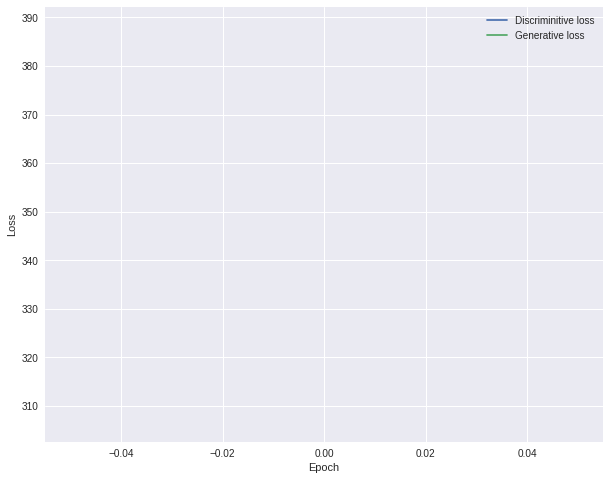

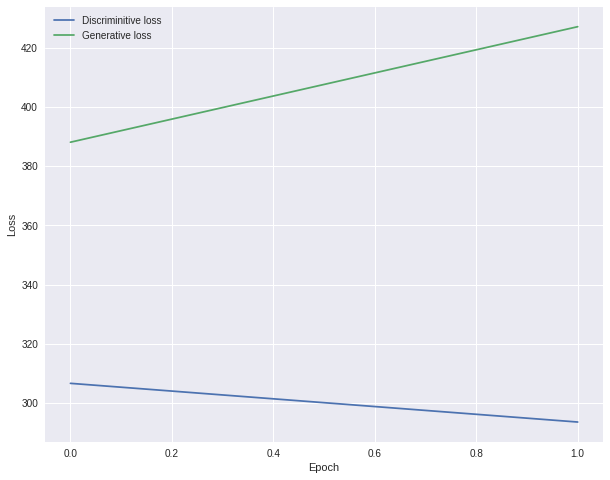

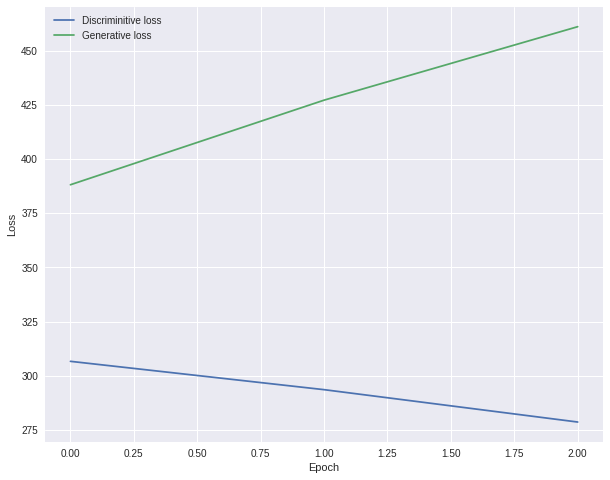

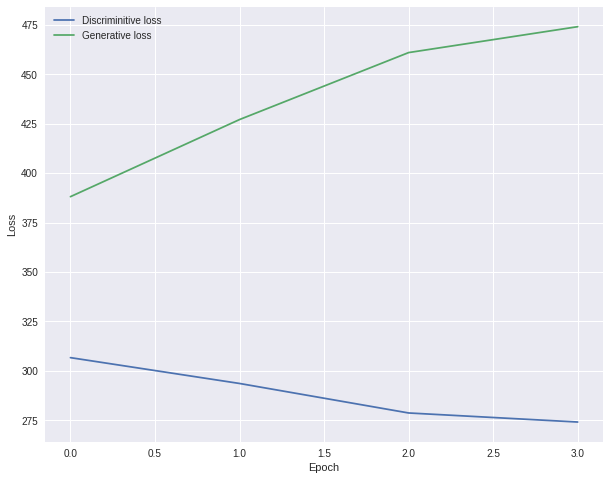

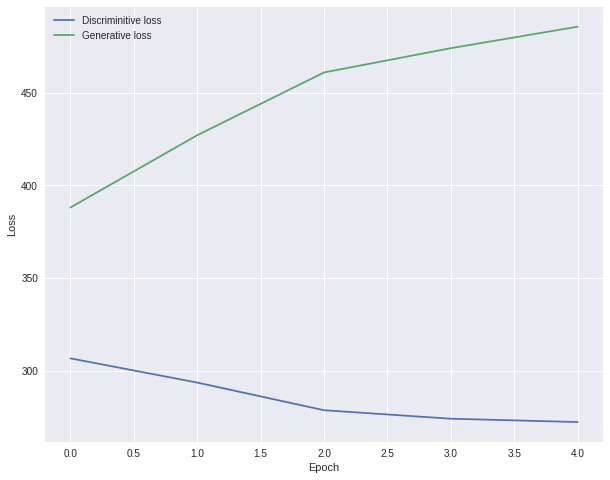

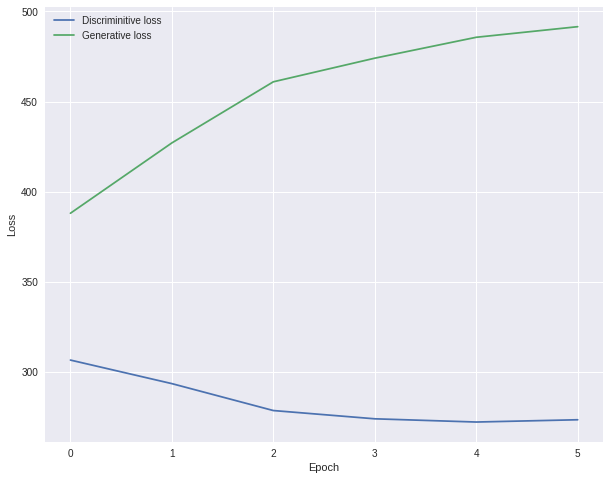

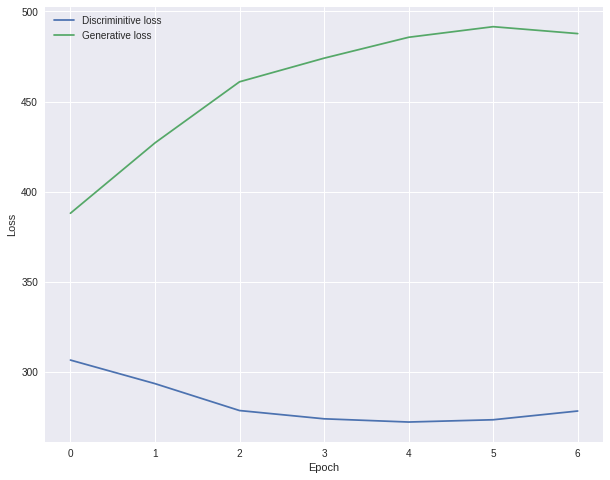

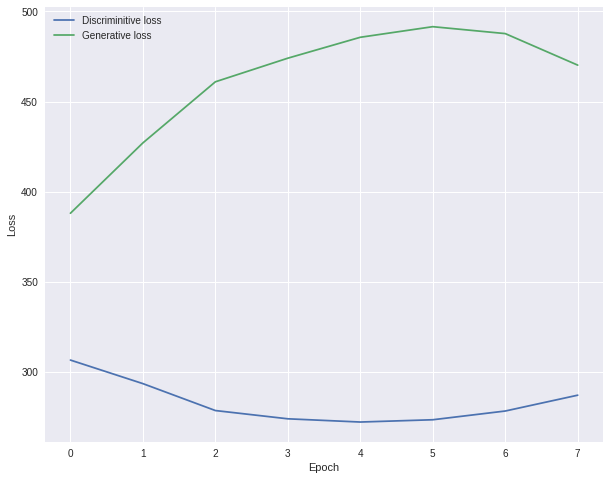

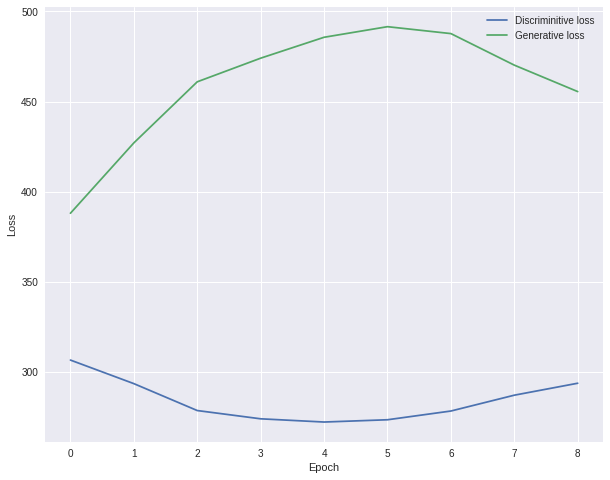

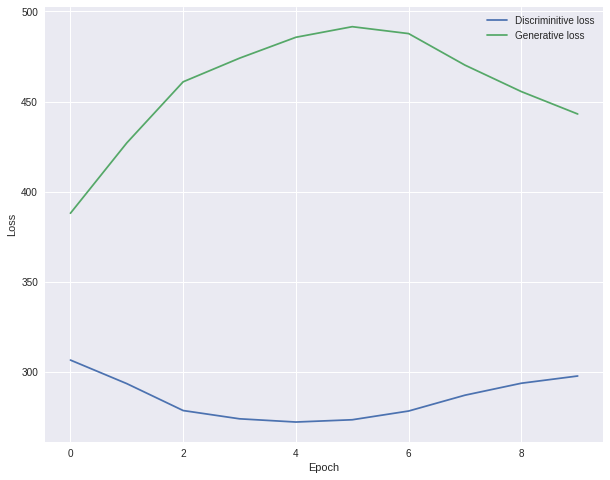

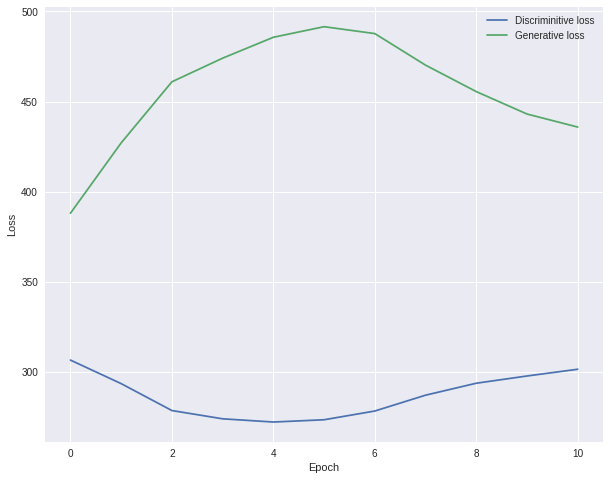

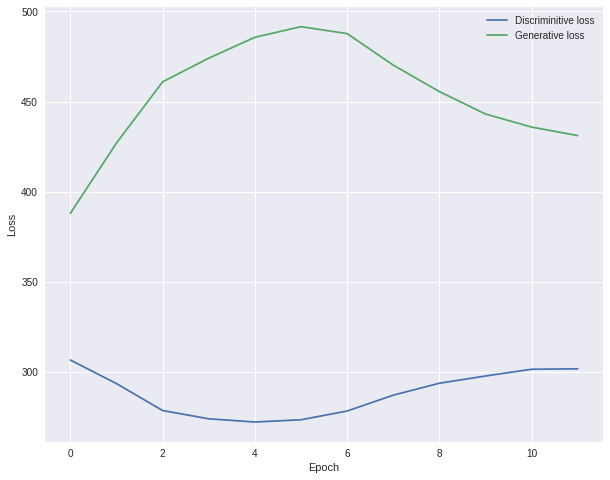

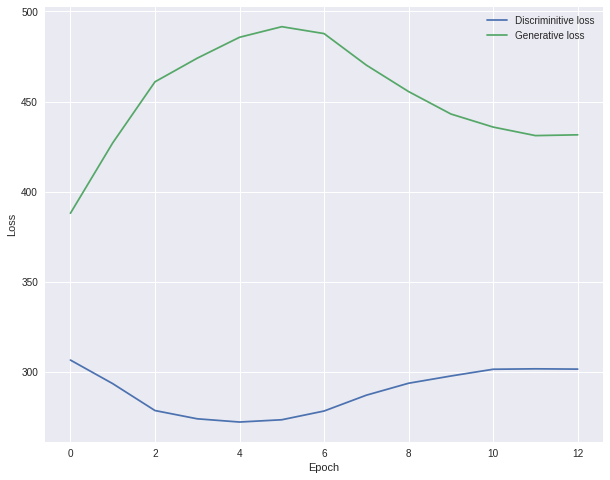

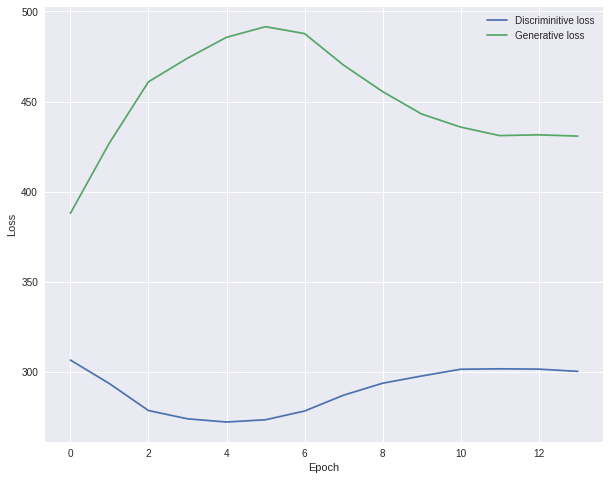

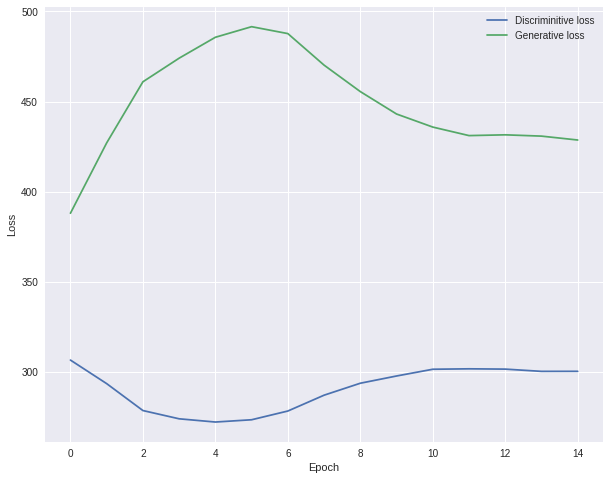

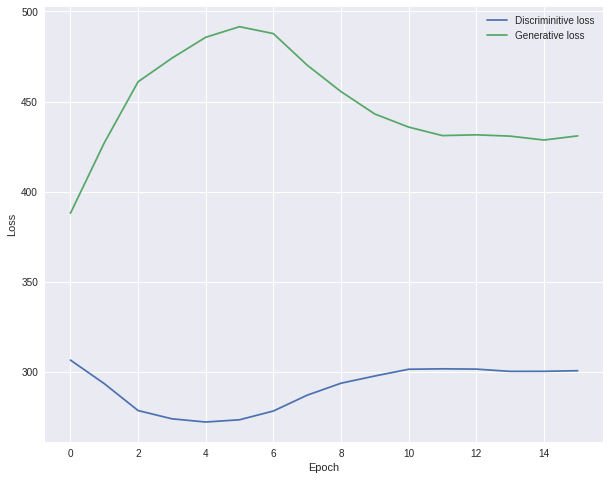

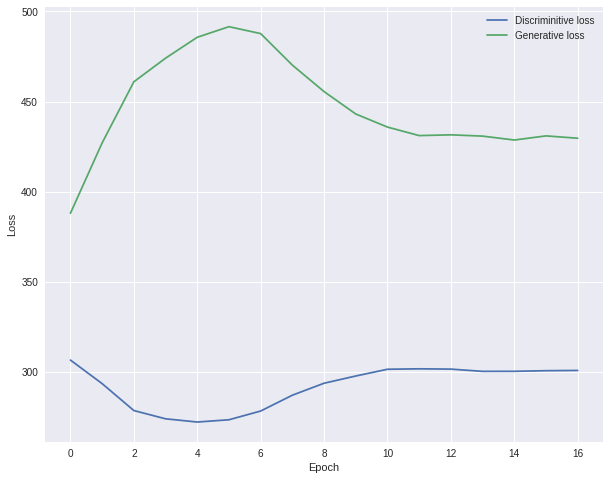

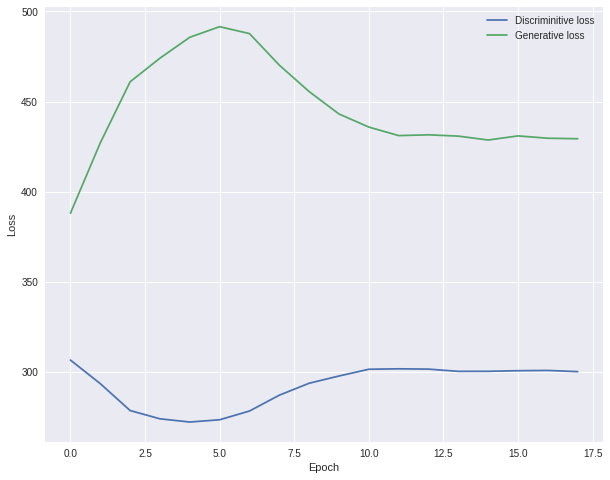

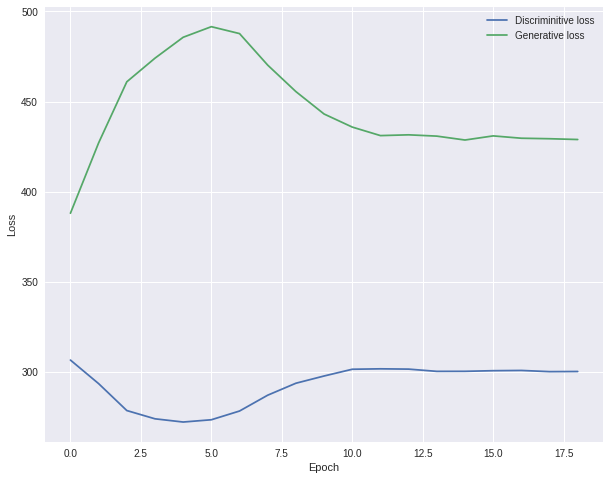

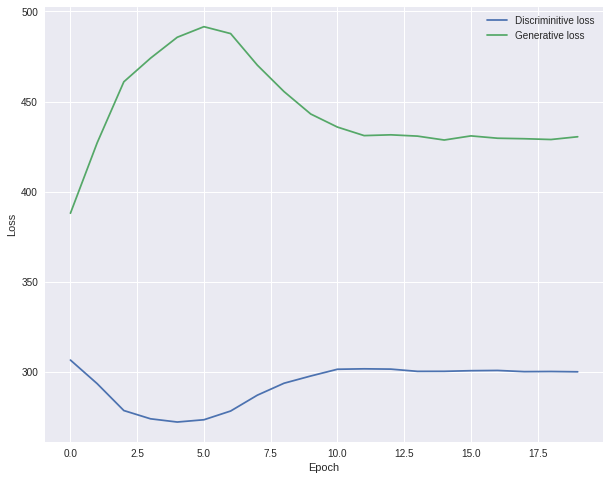

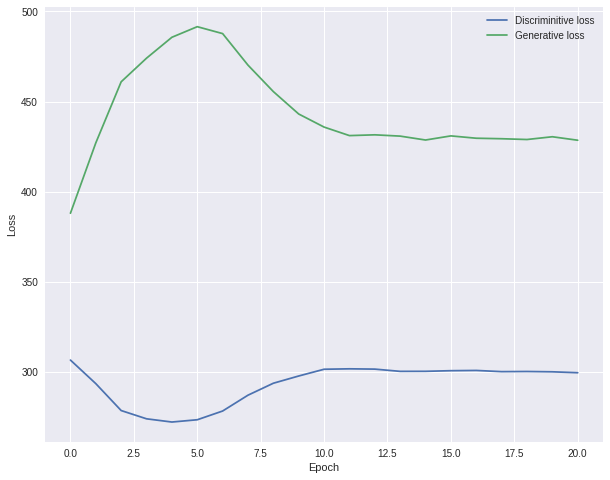

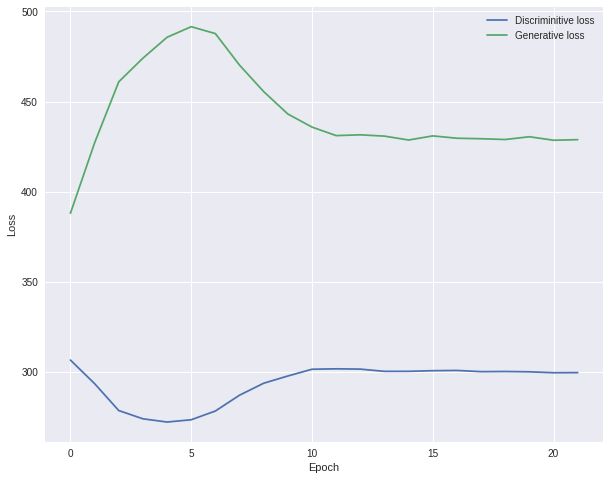

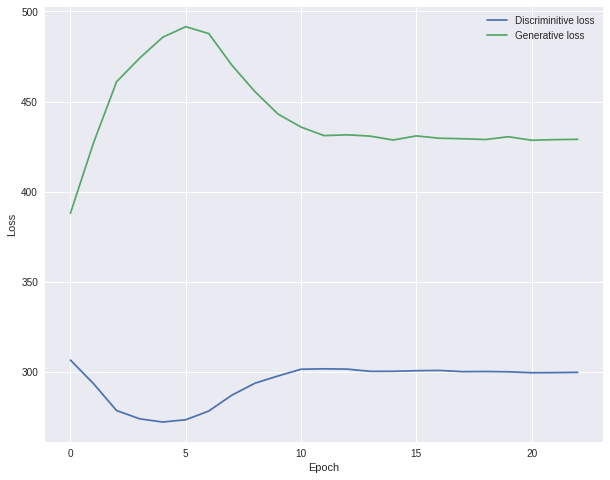

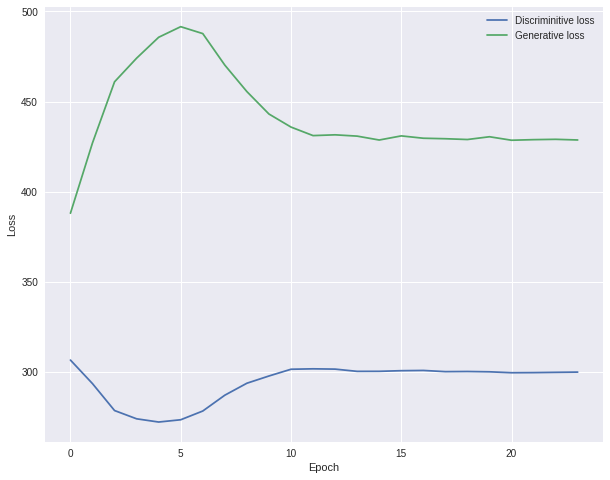

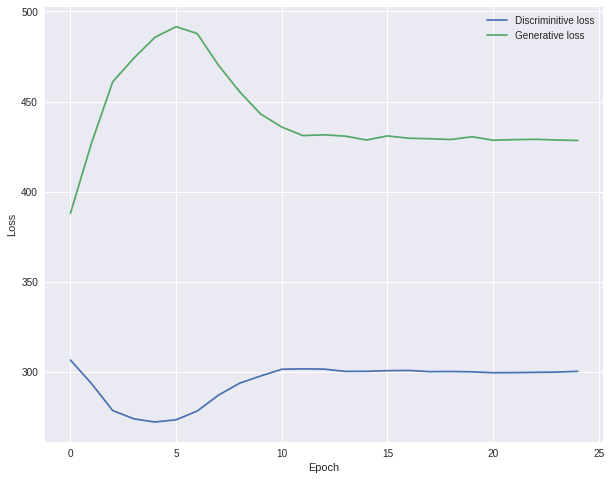

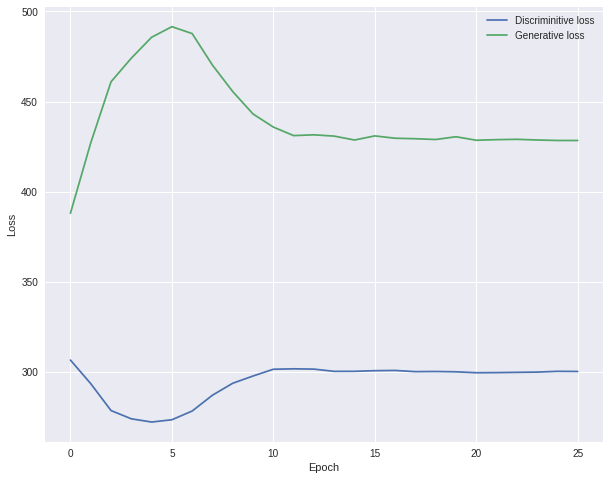

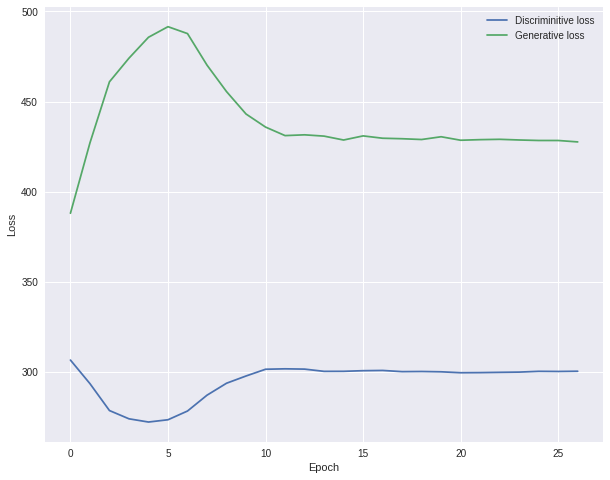

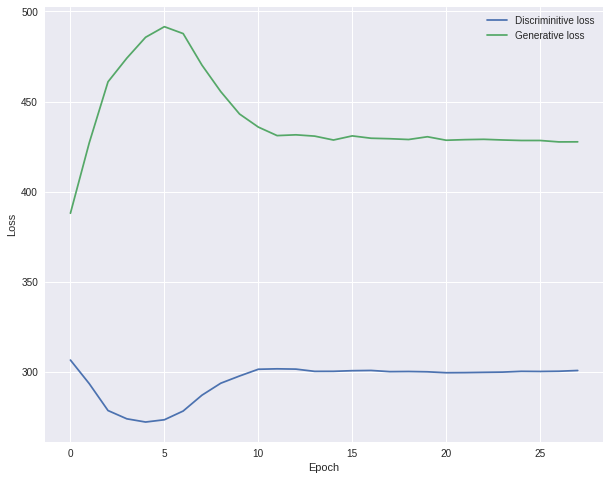

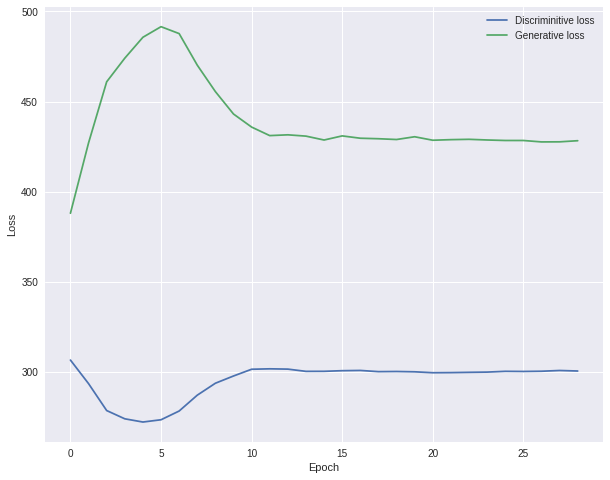

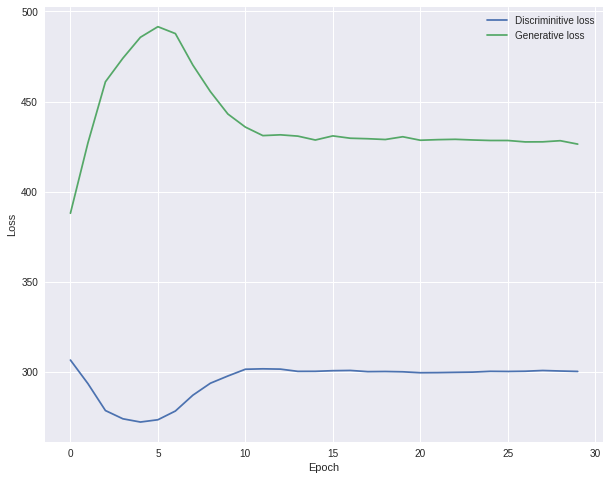

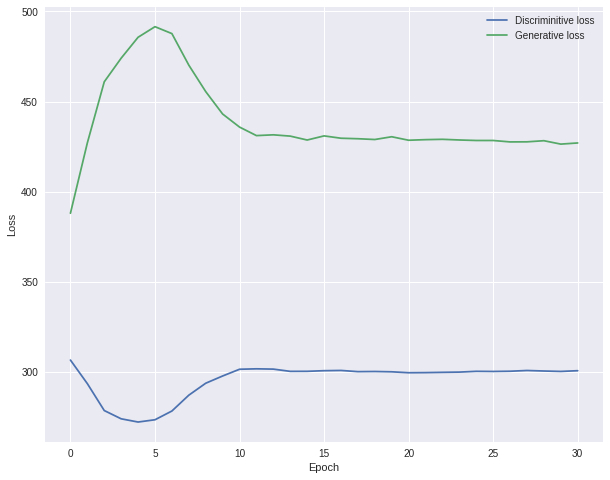

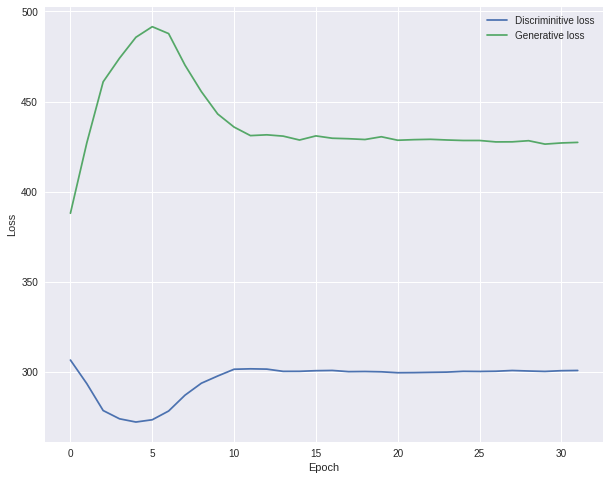

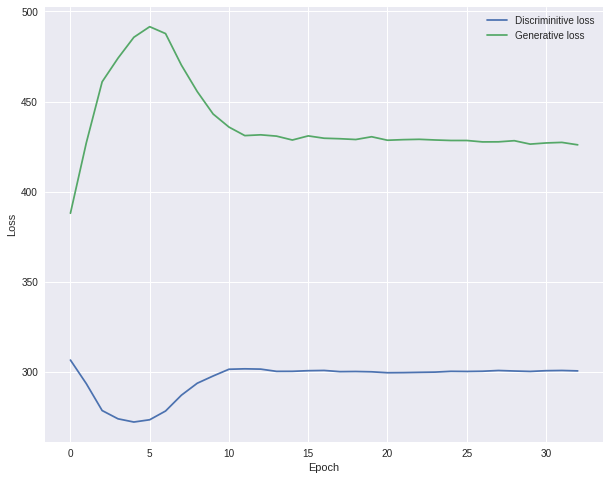

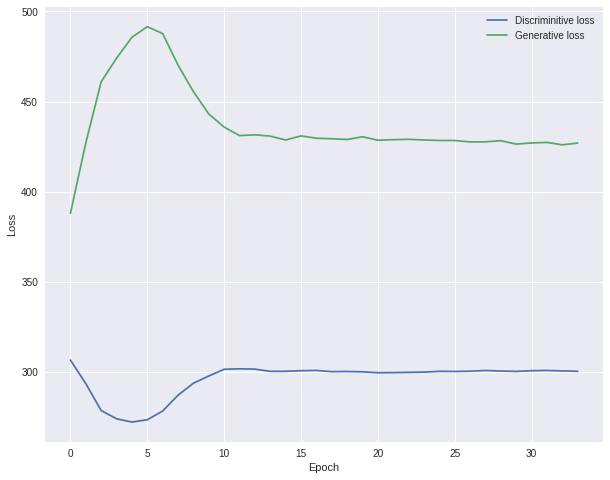

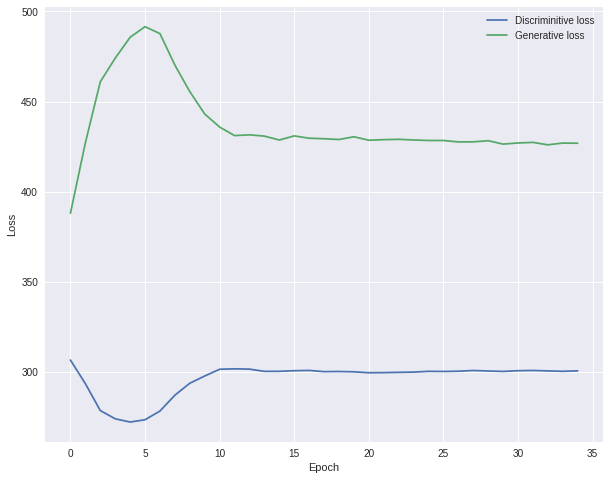

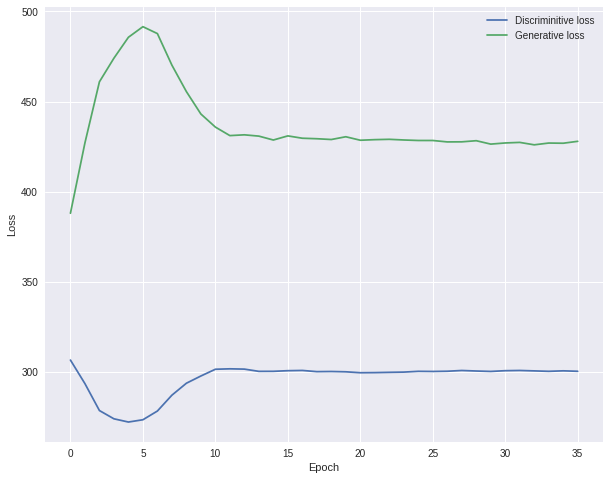

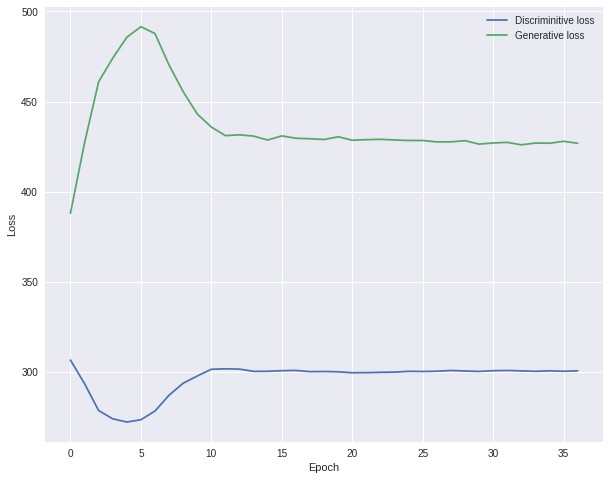

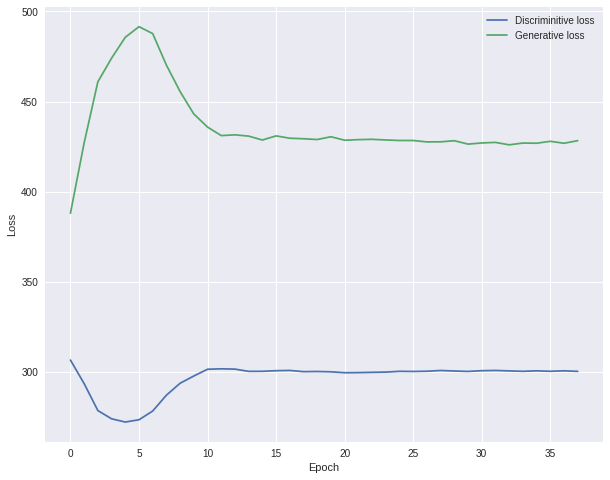

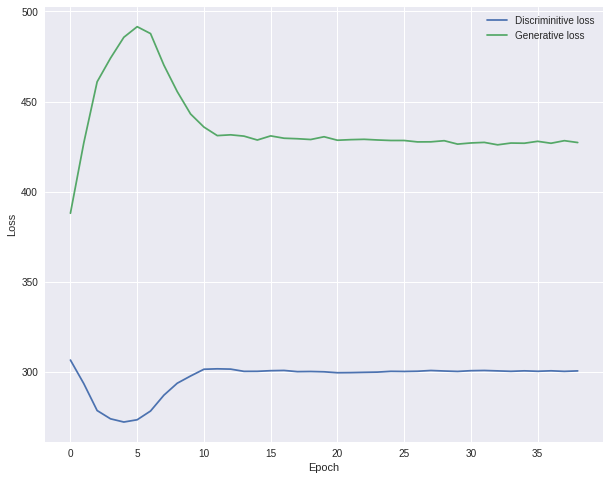

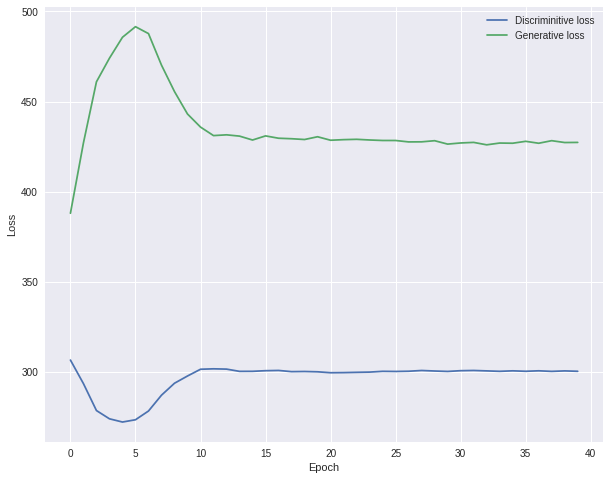

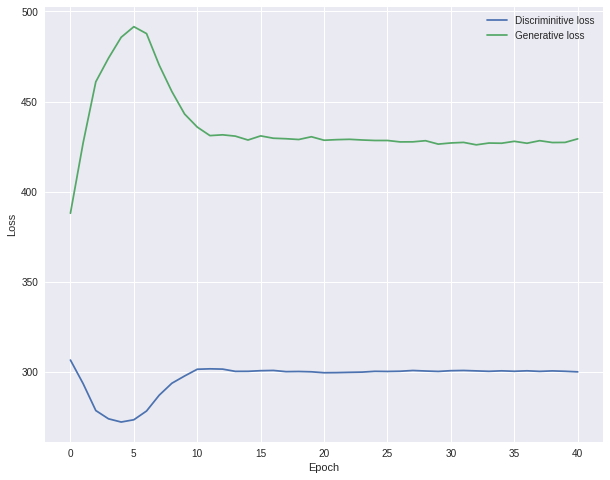

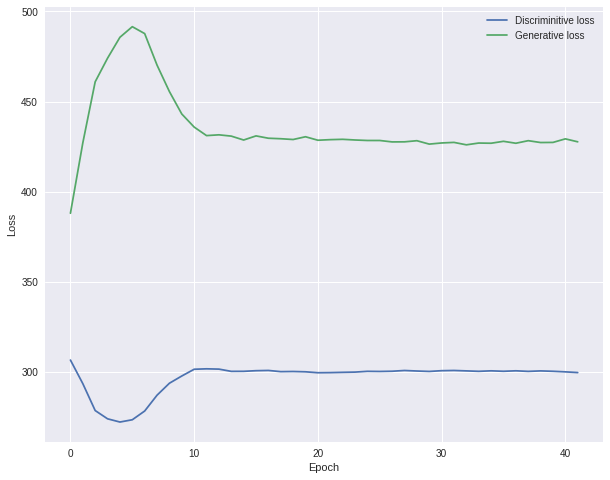

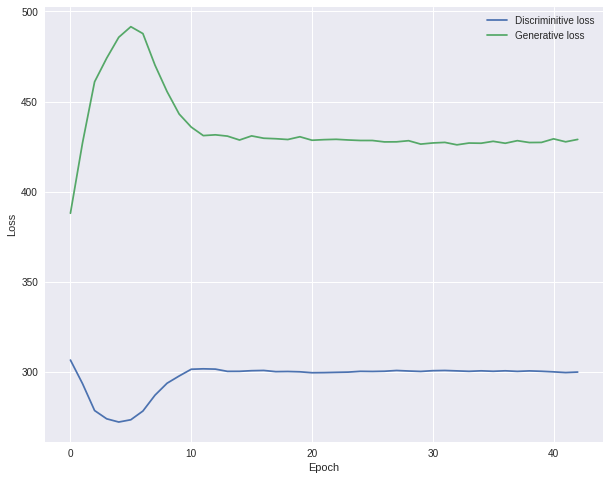

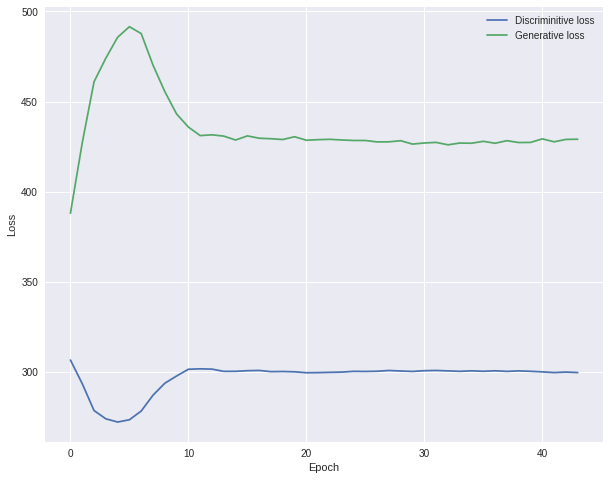

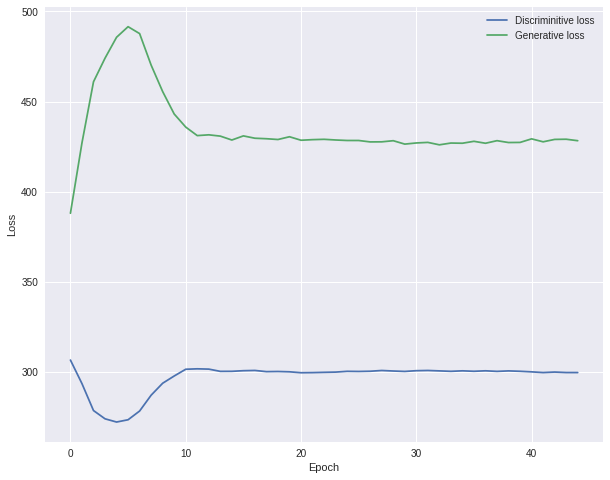

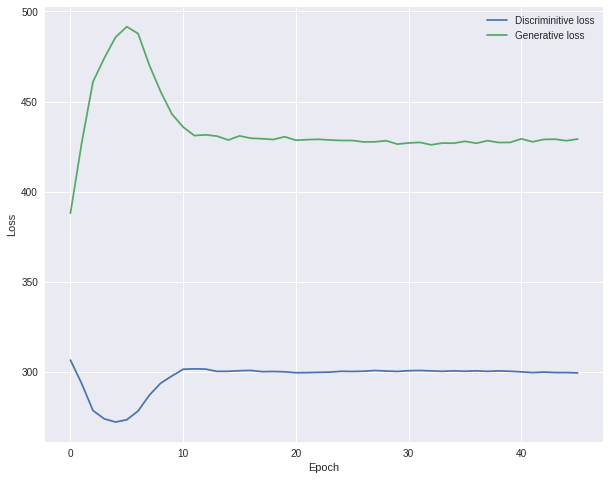

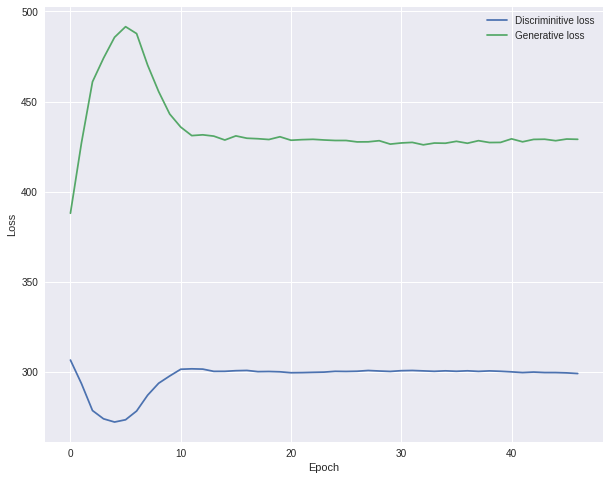

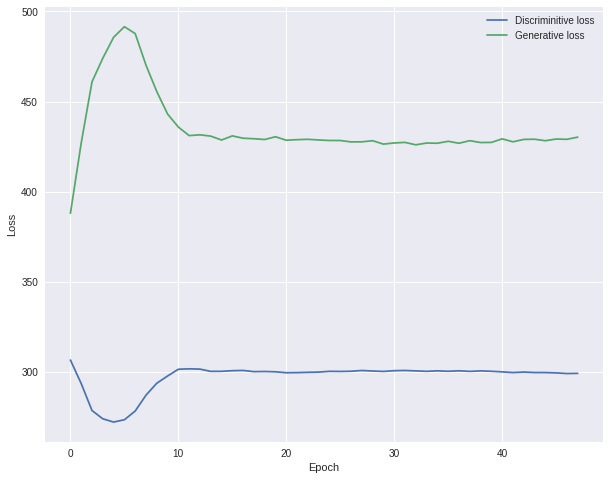

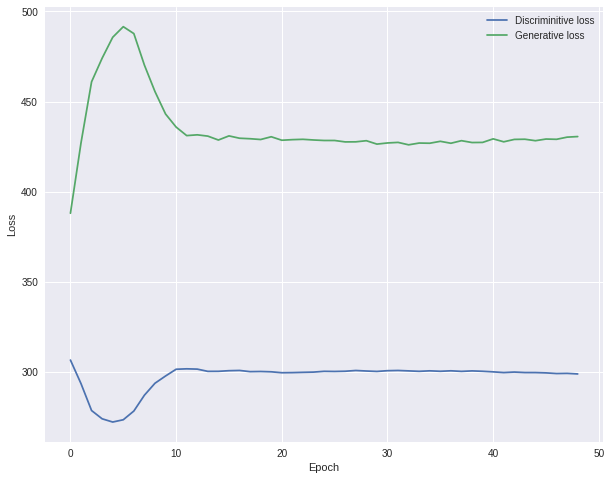

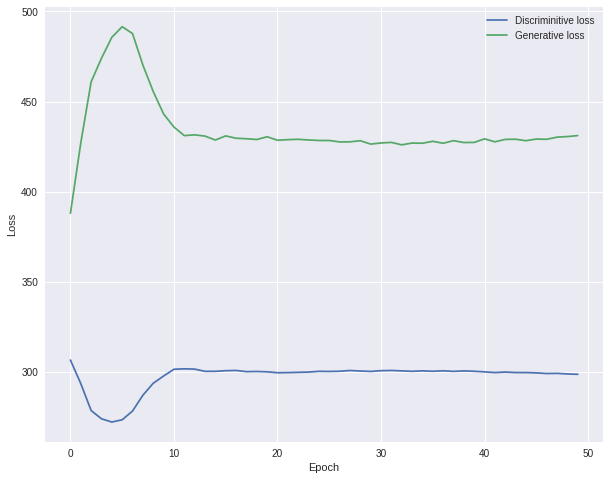

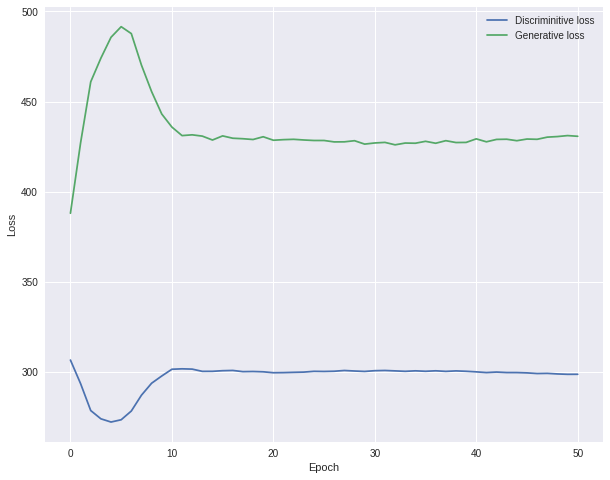

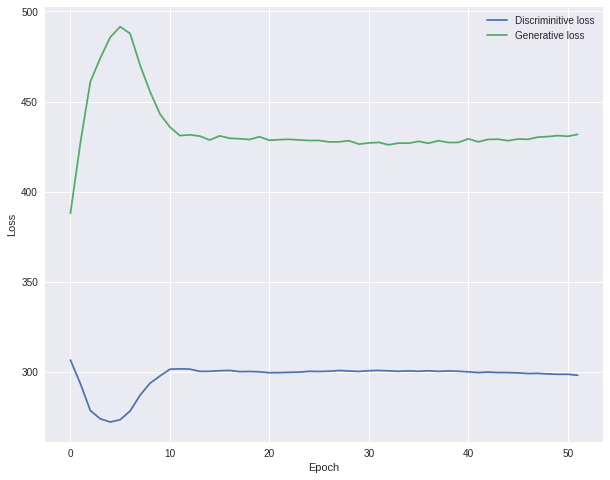

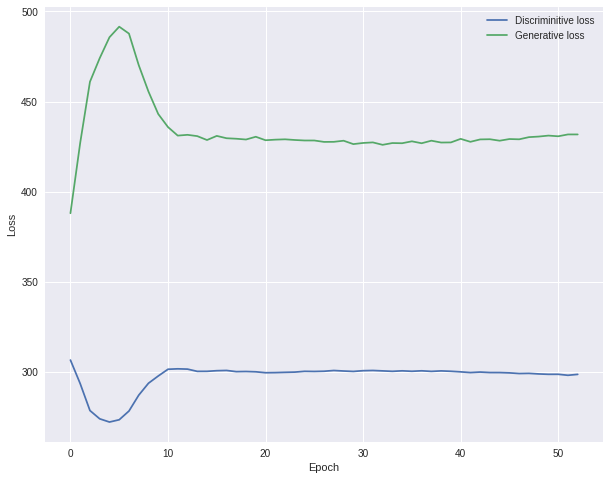

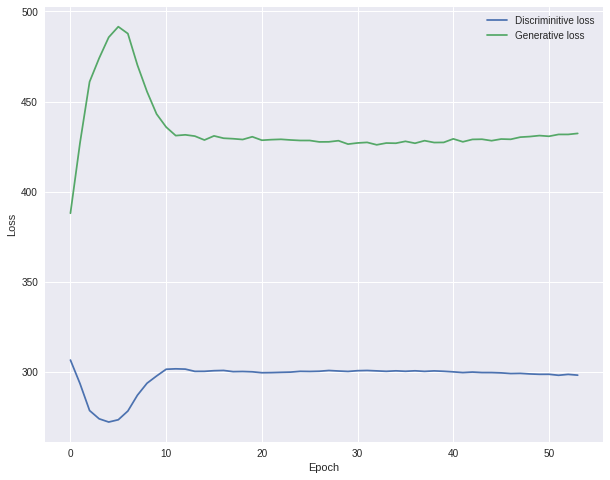

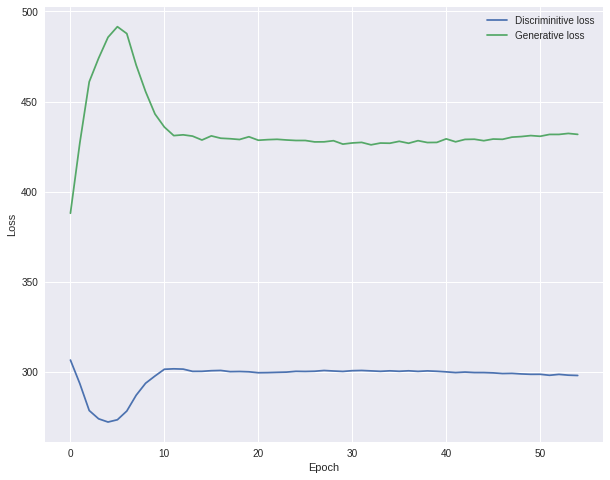

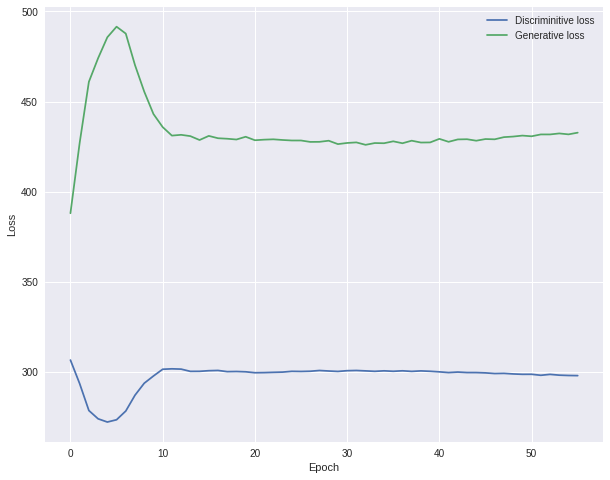

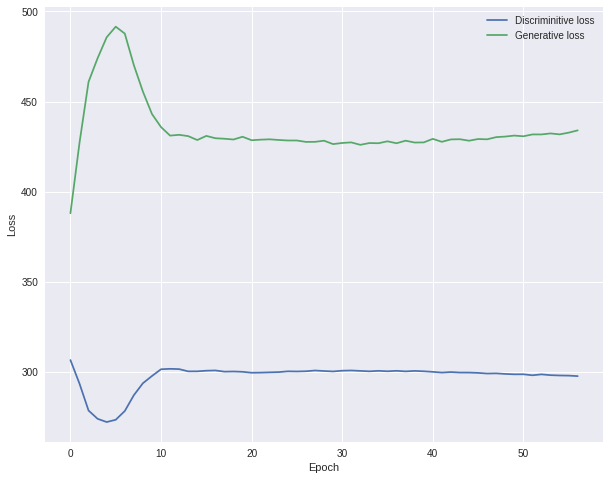

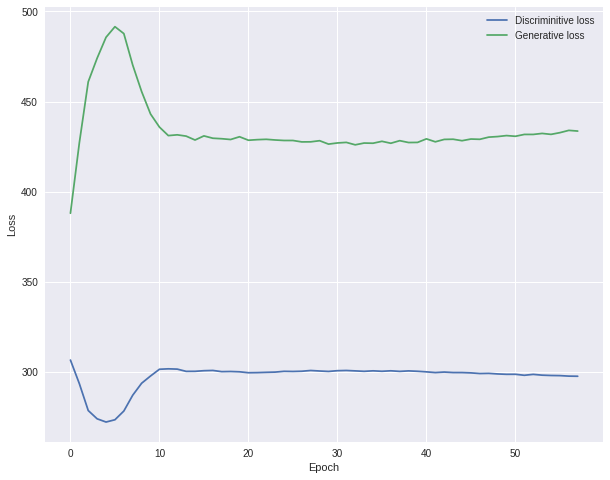

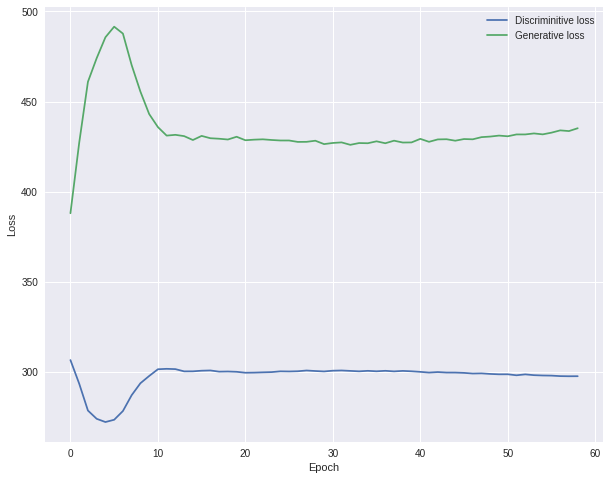

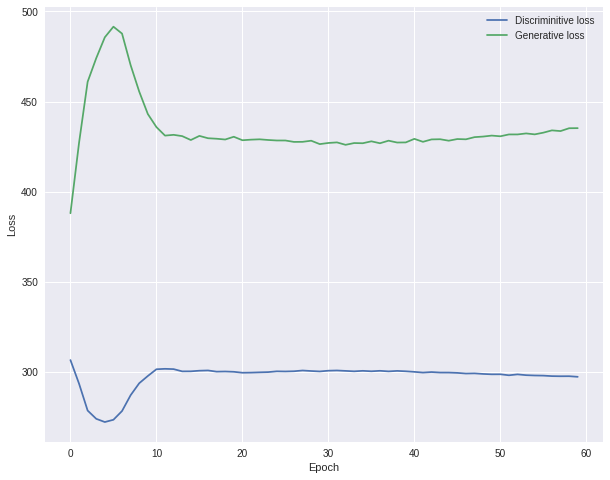

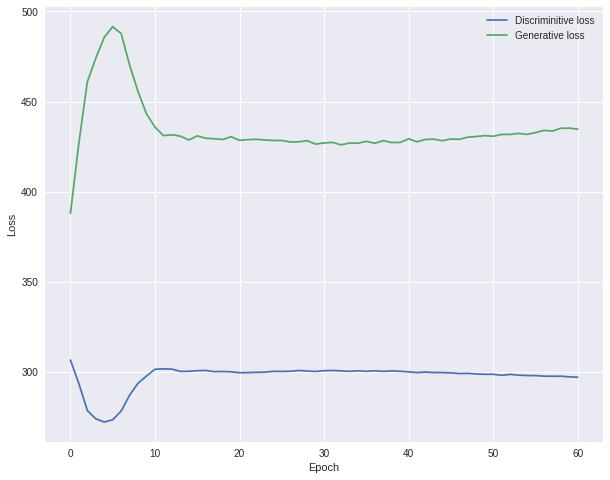

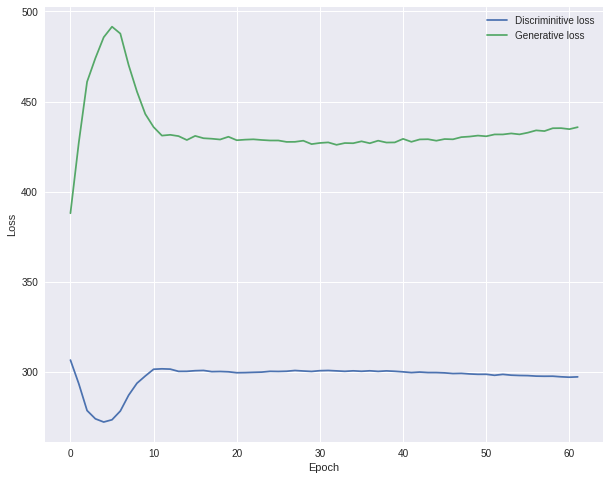

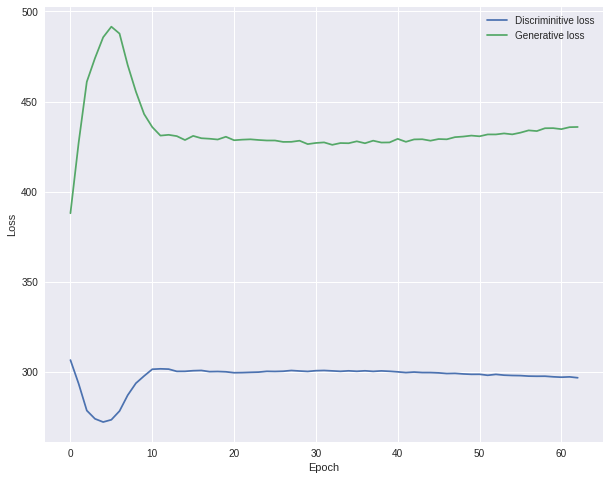

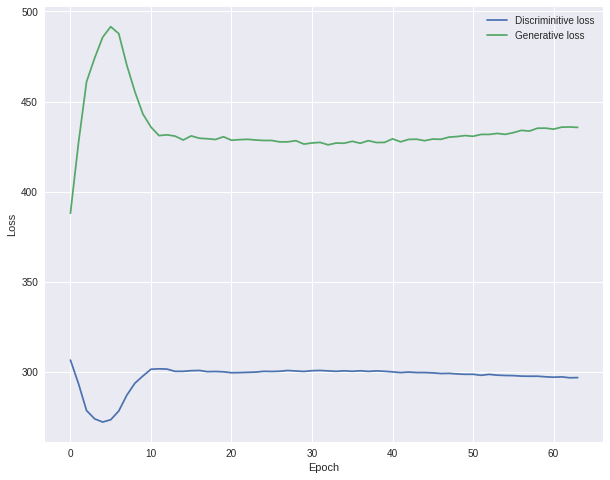

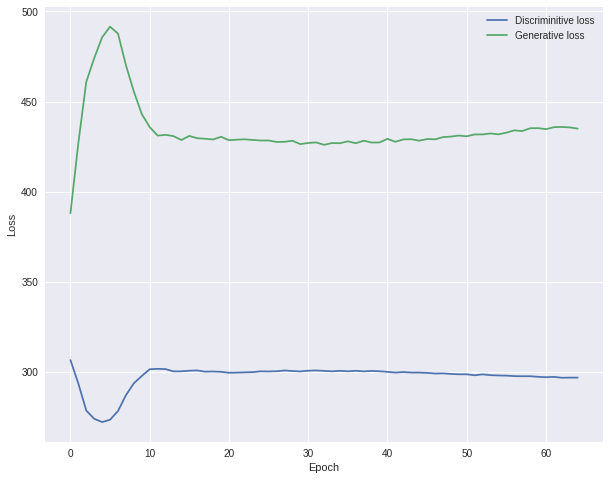

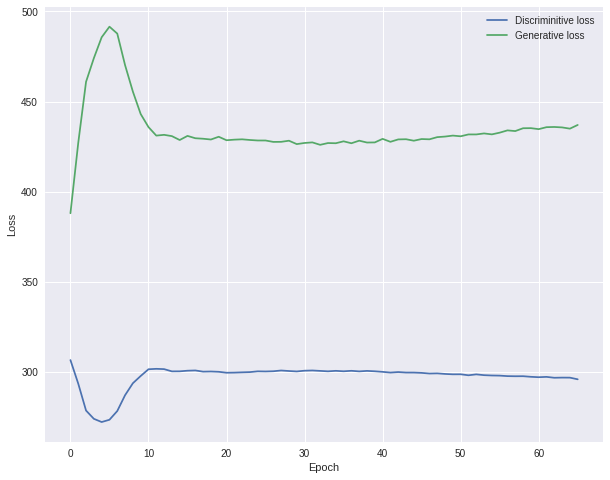

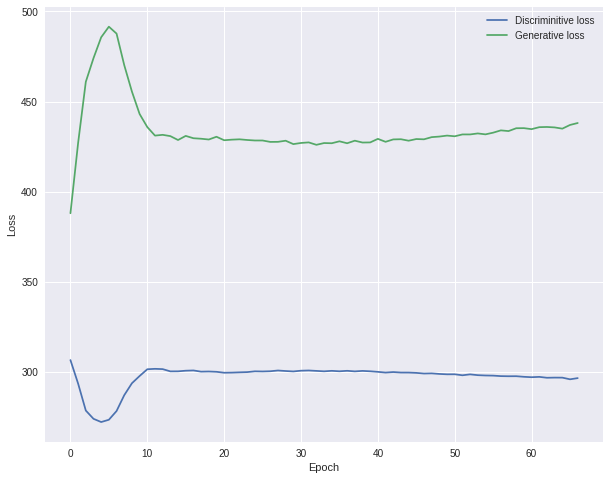

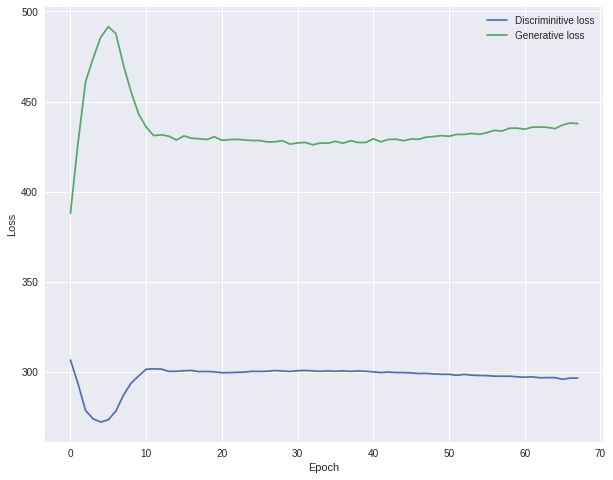

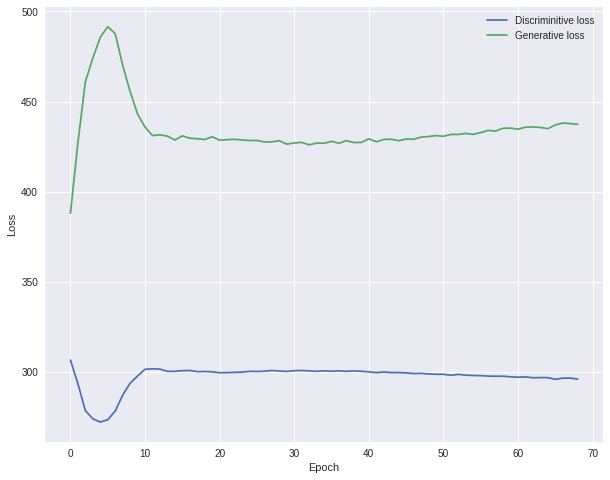

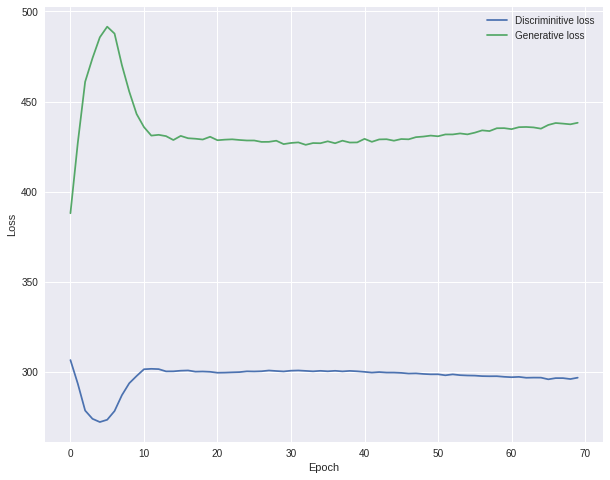

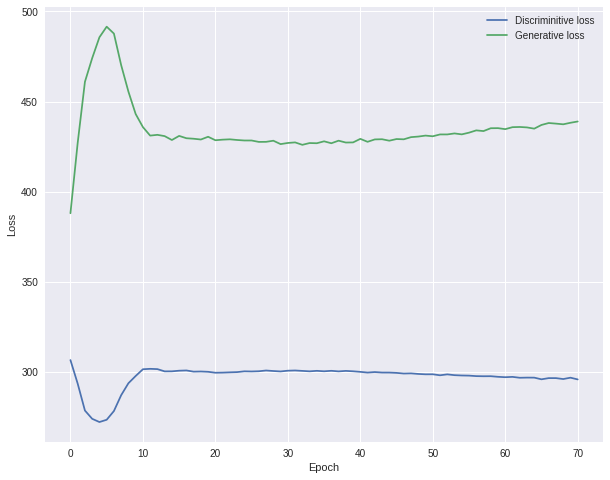

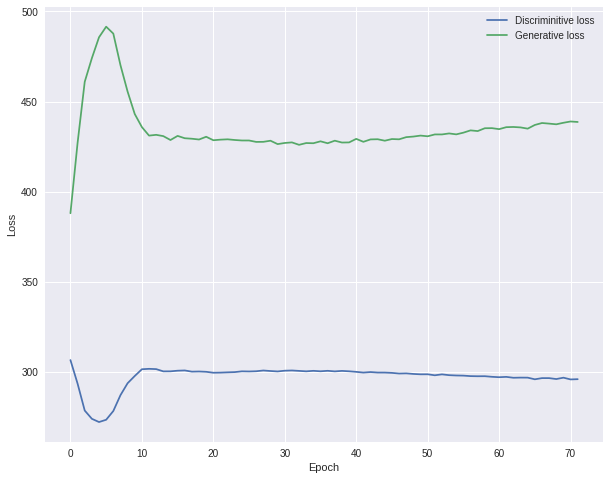

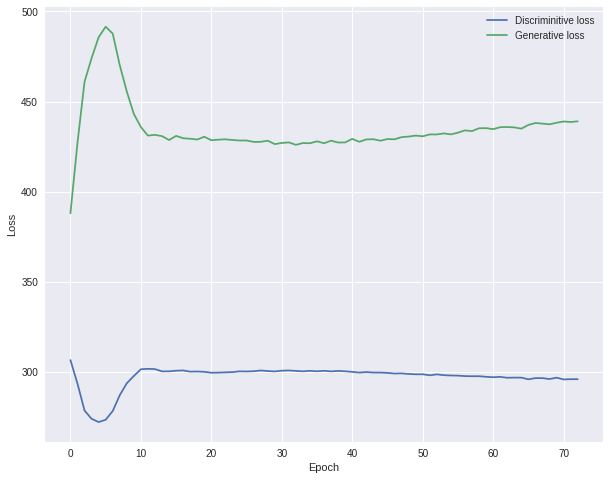

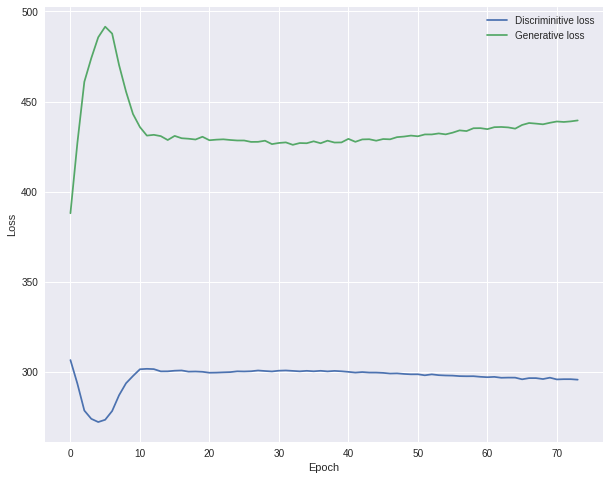

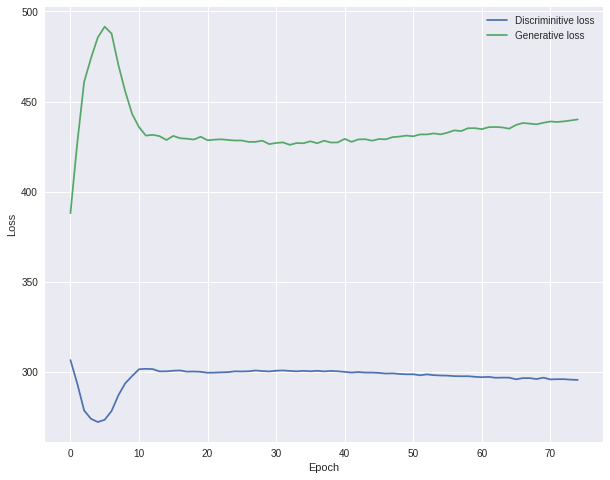

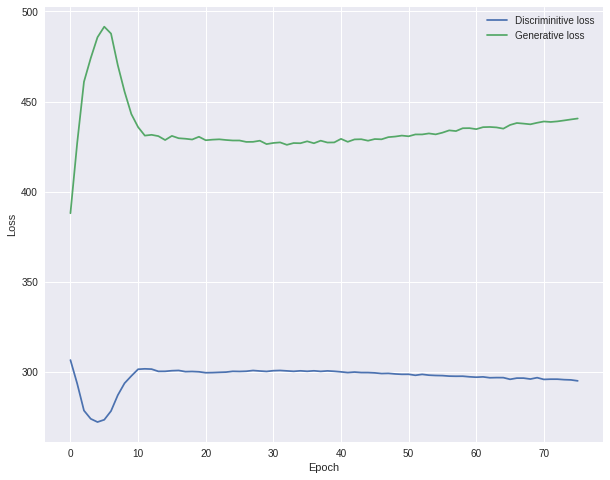

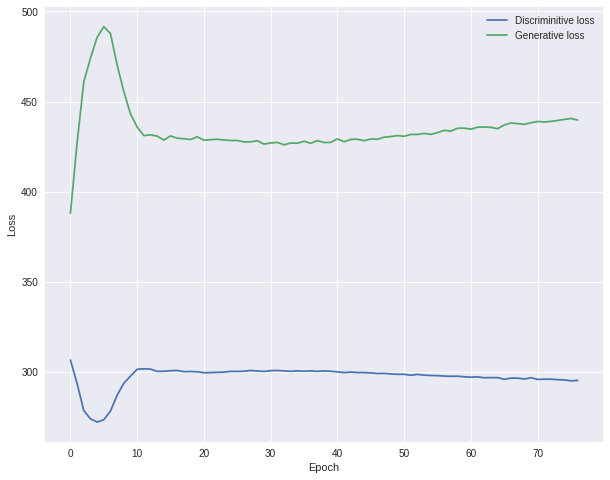

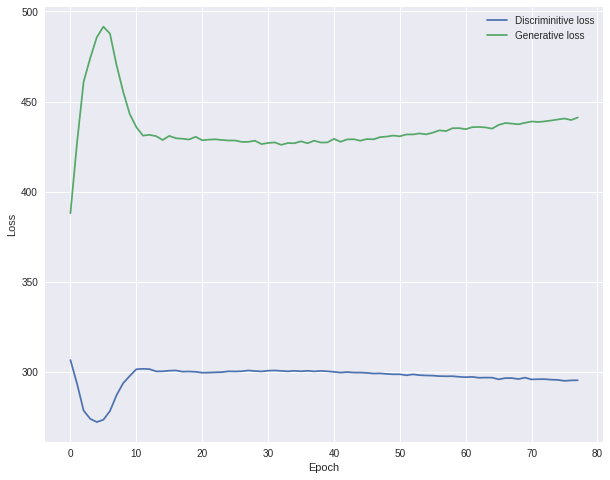

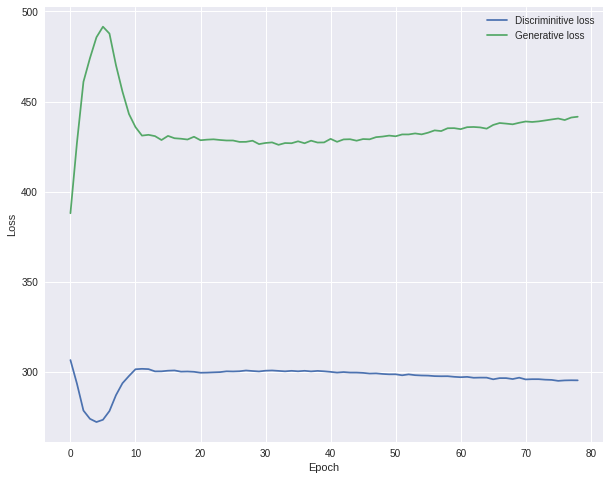

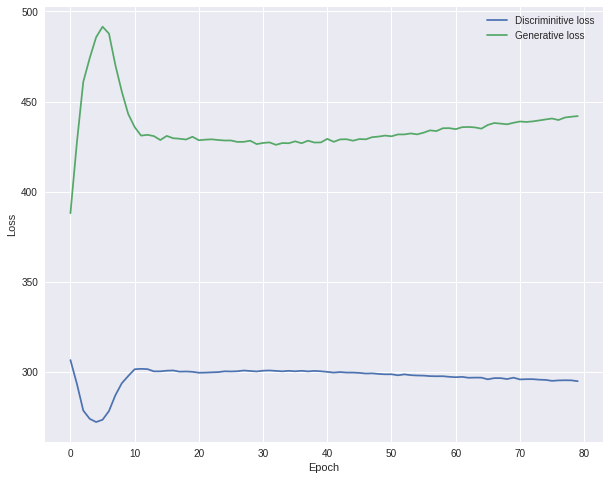

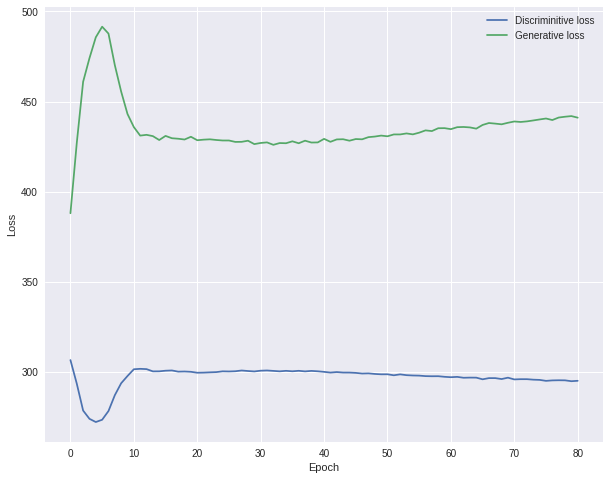

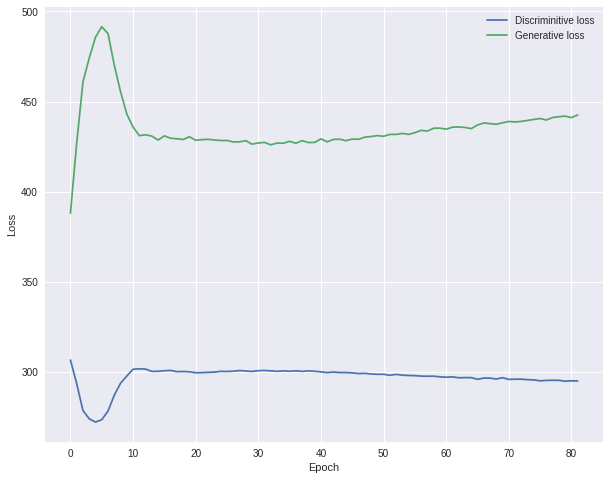

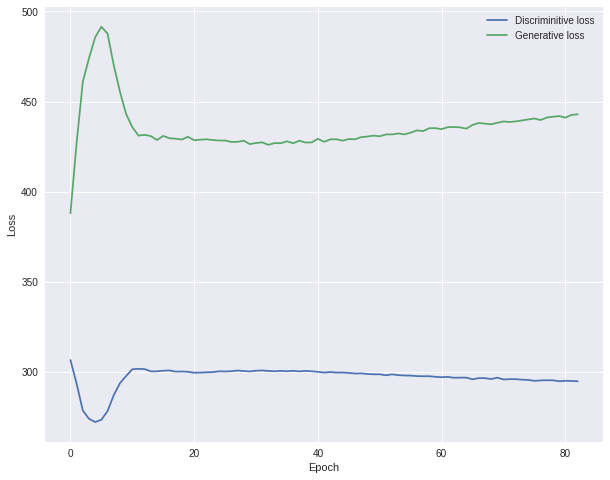

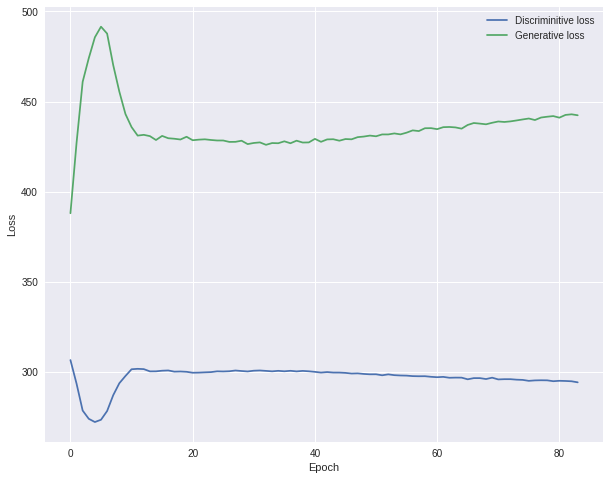

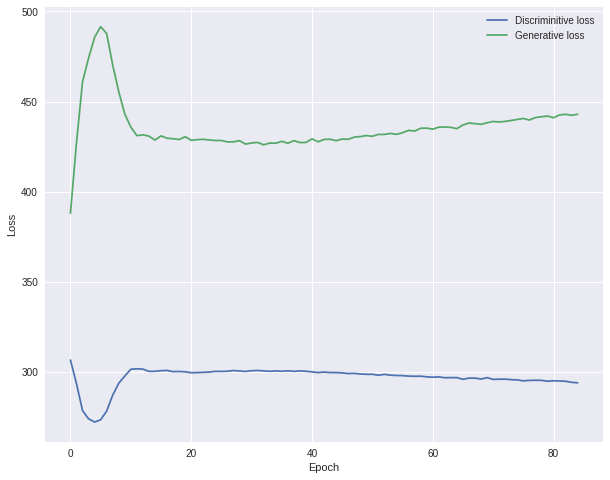

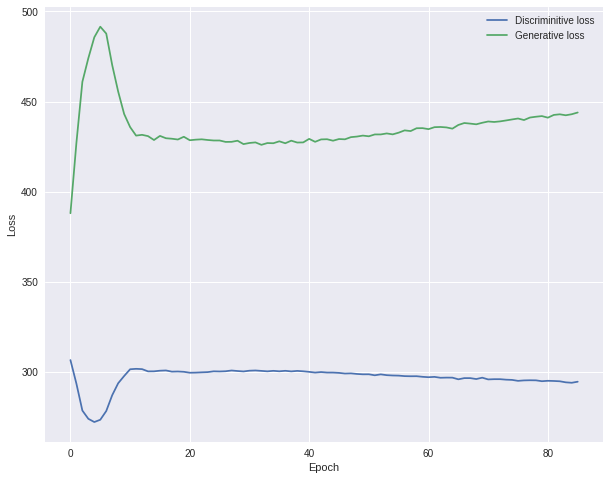

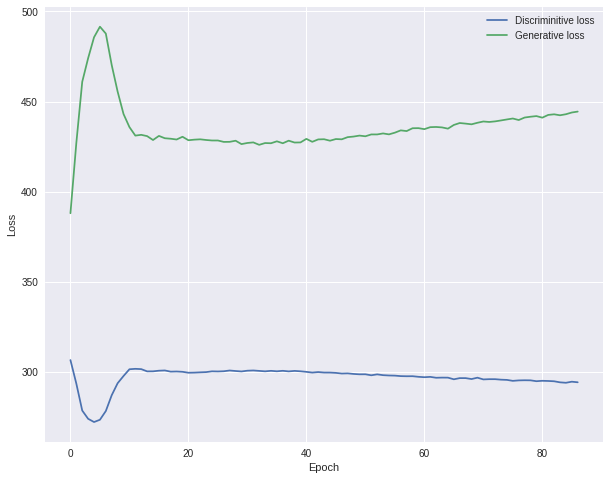

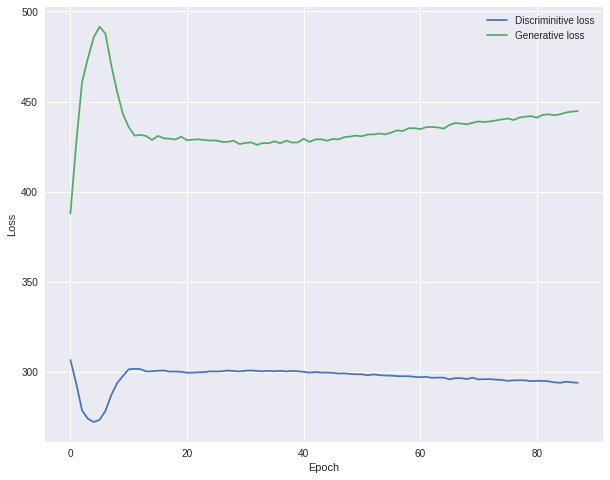

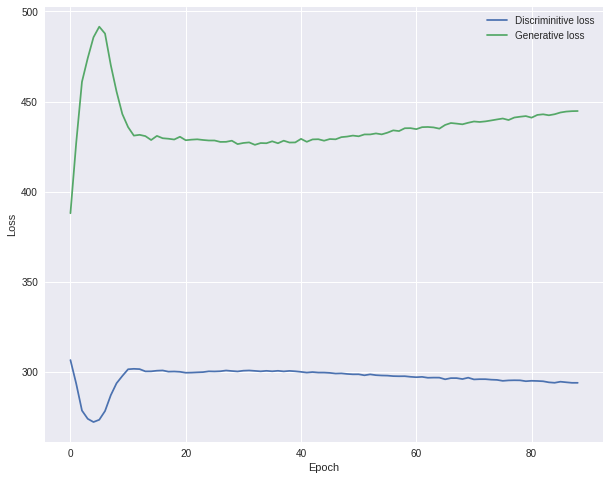

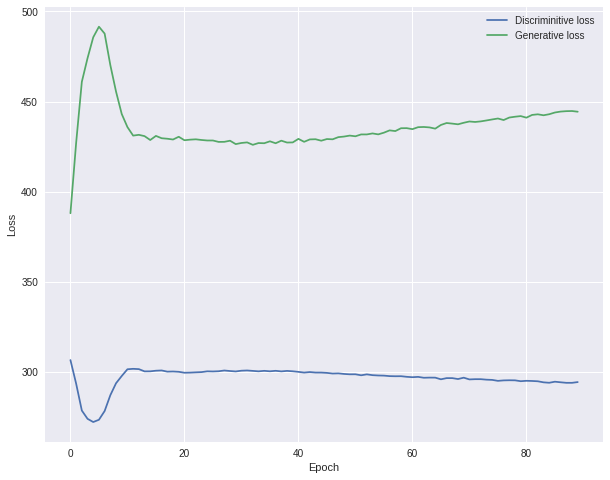

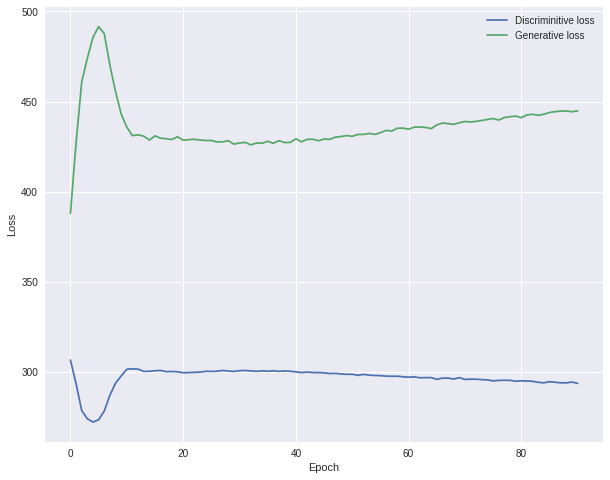

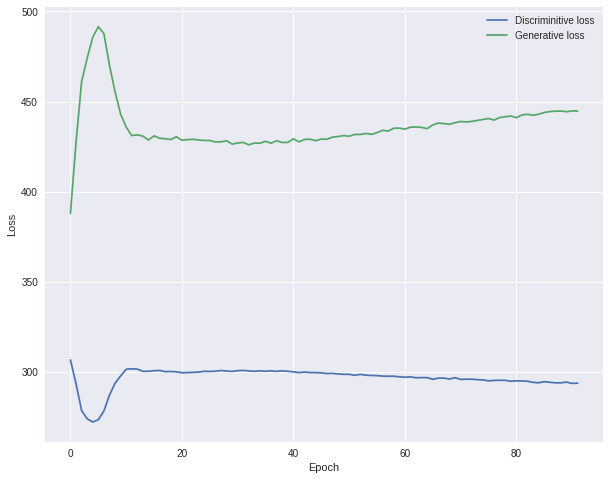

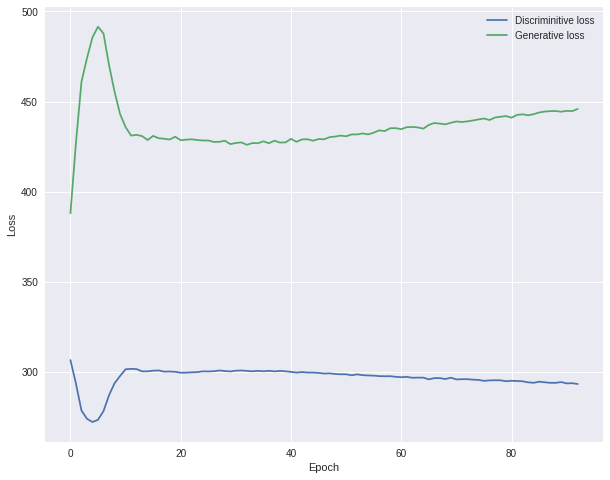

In [16]:
train_GAN(X_train, Y_train, epochs=100, batchSize=128)

# TESTS

In [0]:
#@title SEUILLAGES

"""Importer le modèle à 95-96%"""

model_95=load_model('10_classifier')

#entropie
seuils=np.concatenate((np.linspace(3.3,3.32,4),np.linspace(3.32,3.323,20)))
x=[]
y=[]
lim=10001
current=0
i=0
while i<len(seuils) and current<lim:
  print(str(i+1)+"/"+str(len(seuils)))
  point=test_model_entropie(model_95,seuils[i],x_test,y_test)
  x.append(point[0])
  y.append(point[1])
  i+=1
  current=point[0]

  
o=np.ones(len(x))
plt.plot(x,y,'b',label="entropie")
plt.plot(x,o,'r')

#max
seuils=np.concatenate((np.linspace(0,0.1,6),np.linspace(0.1,0.11,10),np.linspace(0.11,1,2)))
x=[]
y=[]
lim=10000
current=0
i=0
while i<len(seuils) and current<lim:
  print(str(i+1)+"/"+str(len(seuils)))
  point=test_model(model_95,seuils[i],x_test,y_test)
  x.append(point[0])
  y.append(point[1])
  print(point)
  i+=1
  current=point[0]


plt.plot(x,y,'g',label="max")
plt.xlabel("Nombre d'images rejetées")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# DERNIERS CHANGEMENTS / ETAT DES LIEUX

Ajout du code d'Artieres : TERMINE

Test du code d'Artieres : OK
- Entraînement : OK
- Tests : OK
- Autres fonctions : OK

Codes d'entraînement séparés : EN COURS
- GAN seul : A TESTER
- Création BDD : A FAIRE
- REJECTOR seul : A FAIRE
- CLASSIFIEUR seul : A ECRIRE (importer le modèle déjà prêt)

Nouvelles fonctions de choix des exemples : A VENIR

METHODE 1 : Curriculum learning

Plusieurs possibilités d'apprentissage progressif :

1) Chaque epoch d'apprentissage du REJECTOR est composée d'exemples générés par l'epoch correspondante du generator et filtrés par le DISCRIMINATOR correspondant

2) Même chose mais on filtre avec le DISCRIMINATOR final

3) Chaque epoch d'apprentissage du REJECTOR est composée d'exemples générés par l'epoch correspondante et d'exemples générés précédemment, filtrés par le DISCRIMINATOR correspondant

4) Même chose mais on filtre avec le DISCRIMINATOR final

[5) Pour chaque epoch, le nième batch est constitué d'images générées par la nième epoch du GAN, filtrées par le DISCRIMINATOR correspondant]

[6) Même chose mais on filtre avec le DISCRIMINATOR final]

7) On commence par générer une grande base de données avec toutes les epochs du GAN, que l'on ordonne grâce à leurs score par le DISCRIMINATOR final pour créer les batchs des différentes epochs

Priorité : METHODE 2 : Traditionnal learning

On commence par générer une base de données avec les différentes epochs du GAN, pour lesquelles on a les options suivantes :
 - filtrer par le DISCRIMINATOR correspondant ou le DISCRIMINATOR final
 - attribuer un poids grâce au score du DISCRIMINATOR final ou non
 - inclure des exemples de MNIST découpés ou non, que l'on peut tester avec le DISCRIMINATOR final ou non
 - mélanger la base de données avant de commencer ou non


Pour la base de données positive, on choisit évidemment les classes retenues de MNIST, et on choisit les éléments de chaque batch aléatoirement avec remise.

A AJOUTER :
 - utilisation de plusieurs GANs ?